# Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install and load packages

In [ ]:
import time
from time import gmtime
from time import strftime

import pickle

import matplotlib
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
from scipy import stats
import scipy.stats
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
try:
  import pymc
except:
  !pip install pymc
  import pymc

try:
  import pint
except:
  !pip install pint
  import pint

try:
  import jax
  import jax.numpy as jnp
  import jax.random as random
  import numpyro
except:
  !pip install numpyro==0.6.0
  import numpyro
  import jax
  import jax.numpy as jnp
  import jax.random as random

import numpyro.distributions as dist
from numpyro.distributions import LogNormal, Normal, Uniform
from numpyro.infer import MCMC, NUTS, init_to_value
from jax.config import config
config.update("jax_enable_x64", True)
numpyro.set_host_device_count(4)

In [ ]:
print(f'Using numpyro {numpyro.__version__}')
print(f'Using jax {jax.__version__}')
print(f'Using jax {pymc.__version__}')

# 2.numpyro

In [ ]:
import os
import numpy as np
import pickle
import arviz as az
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as random
import numpyro

import numpyro.distributions as dist
from numpyro.distributions import LogNormal, Normal, Uniform
from numpyro.infer import MCMC, NUTS, init_to_value
from jax.config import config
config.update("jax_enable_x64", True)
numpyro.set_host_device_count(4)

import glob
import argparse

In [ ]:
dir = "/content/drive/My Drive/ITC/bitc_pymc3-master/bitc_Mg/"
os.path.isdir(dir)

In [ ]:
os.chdir(dir+'bayesian-itc')
from bitc.experiments import ExperimentMicroCal, ExperimentMicroCalWithDummyITC, ExperimentYaml
from bitc.instruments import known_instruments, Instrument

In [ ]:
os.chdir(dir)

out_dir_1 = '1.itc_origin_heat_files'
out_dir_2 = '1.experimental_information'
out_dir_3 = '2.bitc_numpyro_lognomP0_lognomLs'
if not os.path.exists(dir + out_dir_3):
    os.mkdir(out_dir_3)

In [ ]:
parser = argparse.ArgumentParser()

parser.add_argument( "--experimental_design_parameters_dir",  type=str, default="")
parser.add_argument( "--itc_data_dir",                  type=str, default="1.itc_origin_heat_files")
parser.add_argument( "--heat_data_dir",                 type=str, default="1.itc_origin_heat_files")

parser.add_argument( "--exclude_experiments",           type=str, default="")

parser.add_argument( "--script",                        type=str, default = dir)
parser.add_argument( "--heat_file_suffix",              type=str, default =".DAT")

parser.add_argument( "--dc",                            type=float, default=0.1)      # cell concentration relative uncertainty
parser.add_argument( "--ds",                            type=float, default=0.1)      # syringe concentration relative uncertainty

parser.add_argument( "--dummy_itc_file",                action="store_true", default=False)

parser.add_argument( "--uniform_cell_concentration",    action="store_true", default=False)
parser.add_argument( "--uniform_syringe_concentration", action="store_true", default=False)
parser.add_argument( "--concentration_range_factor",    type=float, default=10.)

parser.add_argument( "--niters",                        type=int, default=10000)
parser.add_argument( "--nburn",                         type=int, default=1000)
parser.add_argument( "--nthin",                         type=int, default=2)
parser.add_argument( "--nchain",                        type=int, default=4)
parser.add_argument( "--verbosity",                     type=str, default="-vvv")

import sys
sys.argv=['']
del sys
args = parser.parse_args()

In [ ]:
args.itc_data_dir = dir+out_dir_1
args.heat_data_dir = dir+out_dir_1
args.experimental_design_parameters_dir = dir+out_dir_2
args.dc = 0.1
args.ds = 0.1
args.dummy_itc_file = ' --dummy_itc_file '

In [ ]:
itc_data_files = glob.glob(os.path.join(args.itc_data_dir, "*.itc"))
itc_data_files = [os.path.basename(f) for f in itc_data_files]

exper_names = [f.split(".itc")[0] for f in itc_data_files]
for name in exper_names:
    if not os.path.isfile( os.path.join(args.heat_data_dir, name + args.heat_file_suffix) ):
        print("WARNING: Integrated heat file for " + name + " does not exist")
exper_names = [name for name in exper_names if os.path.isfile( os.path.join(args.heat_data_dir, name + args.heat_file_suffix) ) ]

exclude_experiments = args.exclude_experiments.split()
exper_names = [name for name in exper_names if name not in exclude_experiments]

In [ ]:
# def read_experimental_design_parameters(file_name):                                                                                                                       
#     """
#     file_name   :   str, this file has a specific format and was made by hand
#     return
#         parameters  :   dict    parameters[exper_name]  -> {"syringe_concentration":float, ...}
#     """
#     parameters = {}
#     with open(file_name, "rb") as handle:
#         for line in handle:
#             # if not line.startswith("#"):
#                 entries = line.split()

#                 exper_name = entries[0] + "_" + entries[1]
#                 parameters[exper_name] = {}
#                 parameters[exper_name]["syringe_concentration"] = float(entries[2])
#                 parameters[exper_name]["cell_concentration"]    = float(entries[3])
#                 parameters[exper_name]["number_of_injections"]  = int(entries[5])
#                 parameters[exper_name]["injection_volume"]      = float(entries[6])
#                 parameters[exper_name]["spacing"]               = int(entries[7])
#                 parameters[exper_name]["stir_rate"]             = int(entries[8])
#     return parameters
# parameters = read_experimental_design_parameters(dir+out_dir_1+'/experimental_desgin_parameters.dat')

In [ ]:
# exper_name = 'Mgp5EDTAp05a'

In [ ]:
# # pickle.load(open(file_name, "rb"))
# experiment = pickle.load(open(dir+out_dir_2+'/'+exper_name+'.pickle', "rb") )
# experiment

In [ ]:
# injection_volumes = []
# for inj, injection in enumerate(experiment['injections']):
#     injection_volumes.append(injection.volume.magnitude)
# injection_volumes = np.array(injection_volumes)*1e-6 #in liter
# injection_volumes

In [ ]:
# n_injections = experiment['number_of_injections']

# injection_volumes = []
# for inj, injection in enumerate(experiment['injections']):
#     injection_volumes.append(injection.volume.magnitude)
# injection_volumes = np.array(injection_volumes)*1e-6 #in liter
# SYRINGE_CONCENTR = experiment['syringe_concentration']['ligand'].magnitude        # milli molar
# CELL_CONCENTR = experiment['cell_concentration']['macromolecule'].magnitude        # milli molar

### Functions

In [ ]:
def load_heat_micro_cal(origin_heat_file):
    """
    :param origin_heat_file: str, name of heat file
    :return: 1d ndarray, heats in micro calorie
    """
    heats = []
    with open(origin_heat_file) as handle:
        handle.readline()
        for line in handle:
            if len(line.split()) == 6 or len(line.split()) ==8:
                heats.append(np.float(line.split()[0]))
    return jnp.array(heats)

In [ ]:
def logsigma_guesses(q_n_cal):
    # log_sigma_guess = np.log(q_n_cal[-4:].std())
    log_sigma_guess = jnp.log(q_n_cal[-4:].std())
    log_sigma_min = log_sigma_guess - 10
    log_sigma_max = log_sigma_guess + 5
    return log_sigma_min, log_sigma_max

def deltaH0_guesses(q_n_cal):
    heat_interval = (q_n_cal.max() - q_n_cal.min())
    DeltaH_0_min = q_n_cal.min() - heat_interval
    DeltaH_0_max = q_n_cal.max() + heat_interval
    return DeltaH_0_min, DeltaH_0_max

def lognormal_prior(name, stated_value, uncertainty):
    """
    Define a pymc3 prior for a deimensionless quantity
    :param name: str
    :param stated_value: float
    :uncertainty: float
    :rerurn: numpyro.Lognormal
    """
    m = stated_value
    v = uncertainty ** 2
    # return pymc3.Lognormal(name,
    #                        mu=tt.log(m / tt.sqrt(1 + (v / (m ** 2)))),
    #                        tau=1.0 / tt.log(1 + (v / (m ** 2))),
    #                        testval=m)
    name = numpyro.sample(name, dist.LogNormal(loc=jnp.log(m / jnp.sqrt(1 + (v / (m ** 2)))), 
                                               scale=jnp.sqrt(jnp.log(1 + v / (m**2) )) ))

    return name

def uniform_prior(name, lower, upper):
    """
    :param name: str
    :param lower: float
    :param upper: float
    :return: pymc3.Uniform
    """
    # return pymc3.Uniform(name, lower=lower, upper=upper)
    name = numpyro.sample(name, dist.Uniform(low=lower, high=upper))
    return name

In [ ]:
def heats_TwoComponentBindingModel(V0, DeltaVn, P0, Ls, DeltaG, DeltaH, DeltaH_0, beta, N):
    """
    Expected heats of injection for two-component binding model.

    ARGUMENTS
    V0 - cell volume (liter)
    DeltaVn - injection volumes (liter)
    P0 - Cell concentration (millimolar)
    Ls - Syringe concentration (millimolar)
    DeltaG - free energy of binding (kcal/mol)
    DeltaH - enthalpy of binding (kcal/mol)
    DeltaH_0 - heat of injection (cal)
    beta - inverse temperature * gas constant (mole / kcal)
    N - number of injections

    Returns
    -------
    expected injection heats (calorie)

    """
    Kd = jnp.exp(beta * DeltaG)   # dissociation constant (M)

    # Compute complex concentrations.
    # Pn[n] is the protein concentration in sample cell after n injections
    # (M)
    Pn = jnp.zeros([N], dtype=jnp.float64)
    # Ln[n] is the ligand concentration in sample cell after n injections
    # (M)
    Ln = jnp.zeros([N], dtype=jnp.float64)
    # PLn[n] is the complex concentration in sample cell after n injections
    # (M)
    PLn = jnp.zeros([N], dtype=jnp.float64)

    dcum = 1.0  # cumulative dilution factor (dimensionless)
    for n in range(N):
        # Instantaneous injection model (perfusion)
        # dilution factor for this injection (dimensionless)
        d = 1.0 - (DeltaVn[n] / V0)
        dcum *= d  # cumulative dilution factor
        # total quantity of protein in sample cell after n injections (mol)
        P = V0 * P0 * 1.e-3 * dcum
        # total quantity of ligand in sample cell after n injections (mol)
        L = V0 * Ls * 1.e-3 * (1. - dcum)
        # complex concentration (M)
        #PLn[n] = (0.5 / V0 * ((P + L + Kd * V0) - jnp.sqrt((P + L + Kd * V0) ** 2 - 4 * P * L) ))
        PLn = jax.ops.index_add(PLn, jax.ops.index[n], 0.5 / V0 * ((P + L + Kd * V0) - jnp.sqrt( (P + L + Kd * V0) ** 2 - 4 * P * L) ))
        # PLn = PLn.at[n].add(0.5 / V0 * ((P + L + Kd * V0) - jnp.sqrt( (P + L + Kd * V0) ** 2 - 4 * P * L) ))
        
        # free protein concentration in sample cell after n injections (M)
        #Pn[n] = P / V0 - PLn[n]
        Pn = jax.ops.index_add(Pn, jax.ops.index[n], P/V0 - PLn[n])
        # Pn = Pn.at[n].add(P / V0 - PLn[n])
        # free ligand concentration in sample cell after n injections (M)
        #Ln[n] = L / V0 - PLn[n]
        Ln = jax.ops.index_add(Ln, jax.ops.index[n], L/V0 - PLn[n])
        # Ln = Ln.at[n].add(L / V0 - PLn[n])

    # Compute expected injection heats.
    # q_n_model[n] is the expected heat from injection n
    q_n = jnp.zeros([N], dtype=jnp.float64)
    # Instantaneous injection model (perfusion)
    # first injection
    #q_n[0] = (DeltaH * V0 * PLn[0])*1000. + DeltaH_0
    q_n = jax.ops.index_add(q_n, jax.ops.index[0], (DeltaH * V0 * PLn[0])*1000. + DeltaH_0)
    # q_n = q_n.at[0].add((DeltaH * V0 * PLn[0])*1000. + DeltaH_0)

    for n in range(1, N):
        d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
        # subsequent injections
        #q_n[n] = (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0
        q_n = jax.ops.index_add(q_n, jax.ops.index[n], (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0)
        # q_n = q_n.at[n].add((DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0)

    return jnp.array(q_n)

In [ ]:
def param_2C(q_actual_cal, injection_volumes, cell_concentration, syringe_concentration,
          cell_volume, temperature, dcell, dsyringe,
          uniform_P0=False, uniform_Ls=False, concentration_range_factor=10.0):
    """
    :param cell_concentration: concentration of the sample cell in milli molar, float
    :param syringe_concentration: concentration of the syringe in milli molar, float
    :param cell_volume: volume of sample cell in liter, float #check the instrutment 
    :param temperature: temprature in kelvin, float
    :param dcell: relative uncertainty in cell concentration, float
    :param dsyringe: relative uncertainty in syringe concentration, float
    :param uniform_P0: if True, use uniform prior for cell concentration, bool
    :param P0_min: only use if uniform_P0 is True, float
    :param P0_max: only use if uniform_P0 is True, float
    :param uniform_Ls: if True, use uniform prior for syringe concentration, bool
    :param Ls_min: only use if uniform_Ls is True, float
    :param Ls_max: only use if uniform_Ls is True, float
    """
    
    DeltaH_0_min, DeltaH_0_max = deltaH0_guesses(q_actual_cal)
    log_sigma_min, log_sigma_max = logsigma_guesses(q_actual_cal)

    stated_P0 = cell_concentration
    # print("Stated P0", stated_P0)
    uncertainty_P0 = dcell * stated_P0

    stated_Ls = syringe_concentration
    # print("Stated Ls", stated_Ls)
    uncertainty_Ls = dsyringe * stated_Ls

    # prior for receptor concentration
    if uniform_P0:
        print("Uniform prior for P0")
        assert concentration_range_factor > 1, "concentration_range_factor must be greater than one."
        P0_min = stated_P0/concentration_range_factor
        P0_max = stated_P0*concentration_range_factor
        logger.info("The range is from " + str(P0_min) + " to " + str(P0_max))
        P0 = uniform_prior("P0", lower=P0_min, upper=P0_max)
    else:
        # print("LogNormal prior for P0")
        P0 = lognormal_prior("P0", stated_value=stated_P0, uncertainty=uncertainty_P0)

    # prior for ligand concentration
    if uniform_Ls:
        print("Uniform prior for Ls")
        assert concentration_range_factor > 1, "concentration_range_factor must be greater than one."
        Ls_min = stated_Ls/concentration_range_factor
        Ls_max = stated_Ls*concentration_range_factor
        logger.info("The range is from " + str(Ls_min) + " to " + str(Ls_max))
        Ls = uniform_prior("Ls", lower=Ls_min, upper=Ls_max)
    else:
        # print("LogNormal prior for Ls")
        Ls = lognormal_prior("Ls", stated_value=stated_Ls, uncertainty=uncertainty_Ls)
  
    # prior for DeltaG
    DeltaG = uniform_prior("DeltaG", lower=-40., upper=4.)

    # prior for DeltaH
    DeltaH = uniform_prior("DeltaH", lower=-100., upper=100.)

    # prior for DeltaH_0
    DeltaH_0 = uniform_prior("DeltaH_0", lower=DeltaH_0_min, upper=DeltaH_0_max)

    # prior for log_sigma
    log_sigma = uniform_prior("log_sigma", lower=log_sigma_min, upper=log_sigma_max)

    return P0, Ls, DeltaG, DeltaH, DeltaH_0, log_sigma

def make_TwoComponentBindingModel(q_actual_cal, injection_volumes, cell_concentration, 
                                  syringe_concentration, dcell, dsyringe, 
                                  cell_volume=0.001434, temperature=298.15,
                                  uniform_P0=False, uniform_Ls=False, concentration_range_factor=10.0):
    """
    to create a model
    :param q_actual_cal: observed heats in calorie, array-like
    :param injection_volumes: injection volumes in liter, array-like
    :param cell_concentration: concentration of the sample cell in milli molar, float
    :param syringe_concentration: concentration of the syringe in milli molar, float
    :param cell_volume: volume of sample cell in liter, float #check the instrutment 
    :param temperature: temprature in kelvin, float
    :param dcell: relative uncertainty in cell concentration, float
    :param dsyringe: relative uncertainty in syringe concentration, float
    :param uniform_P0: if True, use uniform prior for cell concentration, bool
    :param P0_min: only use if uniform_P0 is True, float
    :param P0_max: only use if uniform_P0 is True, float
    :param uniform_Ls: if True, use uniform prior for syringe concentration, bool
    :param Ls_min: only use if uniform_Ls is True, float
    :param Ls_max: only use if uniform_Ls is True, float
    
    :return: an instance of numpyro.model
    """
    assert len(q_actual_cal) == len(injection_volumes), "q_actual_cal and injection_volumes must have the same len."
    
    V0 = cell_volume
    DeltaVn = injection_volumes
    beta = 1 / KB / temperature
    n_injections = len(q_actual_cal)
    
    P0, Ls, DeltaG, DeltaH, DeltaH_0, log_sigma = param_2C(q_actual_cal, injection_volumes, 
                                                           cell_concentration, syringe_concentration, 
                                                           cell_volume, temperature, dcell, dsyringe,
                                                           uniform_P0, uniform_Ls, concentration_range_factor)

    sigma_cal = jnp.exp(log_sigma)
    q_model_cal = heats_TwoComponentBindingModel(cell_volume, DeltaVn, P0, Ls, DeltaG, DeltaH, DeltaH_0, beta, n_injections)

    numpyro.sample('q_obs', dist.Normal(loc=q_model_cal, scale=sigma_cal), obs=q_actual_cal)

### numpyro fitting

In [ ]:
jax.local_device_count()

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
def Bayesian_multiple_expt_fitting(rng_key, q_actual_cal, injection_volumes, CELL_CONCENTR,
                                   SYRINGE_CONCENTR, dcell, dsyringe, niters, nburn, nchain, nthin, 
                                   uniform_P0=False, uniform_Ls=False, concentration_range_factor=10.0,
                                   name=None, OUT_DIR=''):
    kernel = NUTS(make_TwoComponentBindingModel)
    nuts = MCMC(kernel, num_warmup=nburn, num_samples=niters, num_chains=nchain, 
                thinning=nthin, progress_bar=False)
    nuts.run(rng_key, q_actual_cal, injection_volumes, CELL_CONCENTR, SYRINGE_CONCENTR, dcell, dsyringe, 
             uniform_P0=uniform_P0, uniform_Ls=uniform_Ls, concentration_range_factor=concentration_range_factor)
    trace = nuts.get_samples(group_by_chain=False)
    pickle.dump(trace, open(os.path.join(OUT_DIR, 'traces.pickle'), "wb"))
    nuts.print_summary()

    data = az.convert_to_inference_data(nuts.get_samples(group_by_chain=True))
    az.plot_trace(data)
    plt.tight_layout();
    plt.savefig(os.path.join(OUT_DIR,'trace_plot.pdf'))

In [ ]:
args.nburn = 10000
args.niters = 100000
args.thin = 10

In [ ]:
dir+out_dir_2+name

In [ ]:
rng_key = random.split(random.PRNGKey(1), 4)
KB = 0.0019872041 # in kcal/mol/K
os.chdir(dir+out_dir_3)
for name in exper_names[:1]: 
    if not os.path.exists(name): 
        os.mkdir(name)
    if not os.path.exists(name+'/'+'traces.pickle'):
        print("Running", name)
        try: 
            itc_file = os.path.join(args.itc_data_dir, name+".itc")
            integ_file = os.path.join(args.heat_data_dir, name + args.heat_file_suffix)
            experiment_design_file = os.path.join(args.experimental_design_parameters_dir, name+'.pickle')

            q_actual_micro_cal = load_heat_micro_cal(integ_file)
            q_actual_cal = q_actual_micro_cal * 1e-6
            
            # n_injections = len(q_actual_cal)
            # INJ_VOL = parameters[name]["injection_volume"]*1e-6               # in liter
            # injection_volumes = [INJ_VOL for _ in range(n_injections)]        # in liter
            # SYRINGE_CONCENTR = parameters[name]["syringe_concentration"]      # milli molar
            # CELL_CONCENTR = parameters[name]['cell_concentration']            # milli molar

            experiment = pickle.load(open(experiment_design_file, "rb") )
            n_injections = experiment['number_of_injections']
            injection_volumes = []
            for inj, injection in enumerate(experiment['injections']):
                injection_volumes.append(injection.volume.magnitude)
            injection_volumes = np.array(injection_volumes)*1e-6                              #in liter
            SYRINGE_CONCENTR = experiment['syringe_concentration']['ligand'].magnitude        # milli molar
            CELL_CONCENTR = experiment['cell_concentration']['macromolecule'].magnitude       # milli molar

            Bayesian_multiple_expt_fitting(rng_key, q_actual_cal, injection_volumes, 
                                           CELL_CONCENTR, SYRINGE_CONCENTR, args.dc, args.ds,
                                           args.niters, args.nburn, args.nchain, args.nthin, 
                                           uniform_P0=args.uniform_cell_concentration, 
                                           uniform_Ls=args.uniform_syringe_concentration, 
                                           concentration_range_factor=args.concentration_range_factor,
                                           name=name, OUT_DIR=name)
        except Exception as e:
            print('Error occurred:\n' + str(e))

In [ ]:
out_dir_3 = '2.bitc_numpyro_lognomP0_lognomLs'
# out_dir_3 = '2.bitc_mcmc_lognomP0_lognomLs'

In [ ]:
name = exper_names[7] 
print(name)

In [ ]:
itc_file = os.path.join(args.itc_data_dir, name+".itc")
integ_file = os.path.join(args.heat_data_dir, name + args.heat_file_suffix)
experiment_design_file = os.path.join(args.experimental_design_parameters_dir, name+'.pickle')

q_actual_micro_cal = load_heat_micro_cal(integ_file)
q_actual_cal = q_actual_micro_cal * 1e-6

experiment = pickle.load(open(experiment_design_file, "rb") )
n_injections = experiment['number_of_injections']
injection_volumes = []
for inj, injection in enumerate(experiment['injections']):
    injection_volumes.append(injection.volume.magnitude)
injection_volumes = np.array(injection_volumes)*1e-6                              #in liter
SYRINGE_CONCENTR = experiment['syringe_concentration']['ligand'].magnitude        # milli molar
CELL_CONCENTR = experiment['cell_concentration']['macromolecule'].magnitude       # milli molar

trace = pickle.load(open(os.path.join(dir+out_dir_3+"/repeat_0/"+name, "traces.pickle"), "rb") )

In [ ]:
params = []
params_name = ["P0", "Ls", "DeltaG", "DeltaH", "DeltaH_0", "log_sigma"] 
for i in params_name: 
    params.append(np.mean(trace[i]))
params = np.array(params)
print(params)

In [ ]:
beta = 1/KB/298.15
q_model = heats_TwoComponentBindingModel(0.001434, injection_volumes, *params[0:5], beta, n_injections)

total_injected_volume = np.cumsum(injection_volumes)
plt.plot(total_injected_volume*1e3, q_actual_cal*1e6, '.', label = "Observed data")
plt.plot(total_injected_volume*1e3, q_model*1e6, '-', label = "Predicted data")
plt.xlabel('Cumulative injection volume (mL)')
plt.ylabel('Injection heat (ucal)')
plt.title('Bayesian model - '+name)
plt.legend()
plt.tight_layout();

In [ ]:
plt.hist((q_actual_cal-q_model)*1e6)
plt.title('Bayesian model - '+name);

# 2.MLE

### Functions

In [ ]:
def load_heat_micro_cal(origin_heat_file):
    """
    :param origin_heat_file: str, name of heat file
    :return: 1d ndarray, heats in micro calorie
    """
    heats = []
    with open(origin_heat_file) as handle:
        handle.readline()
        for line in handle:
            if len(line.split()) == 6 or len(line.split()) == 8:
                heats.append(np.float(line.split()[0]))
    return np.array(heats)

In [ ]:
def heats_TwoComponentBindingModel(P0, Ls, DeltaG, DeltaH, DeltaH_0, V0, DeltaVn, beta, N):
    """
    Expected heats of injection for two-component binding model.

    ARGUMENTS
    V0 - cell volume (liter)
    DeltaVn - injection volumes (liter)
    P0 - Cell concentration (millimolar)
    Ls - Syringe concentration (millimolar)
    DeltaG - free energy of binding (kcal/mol)
    DeltaH - enthalpy of binding (kcal/mol)
    DeltaH_0 - heat of injection (ucal)
    beta - inverse temperature * gas constant (mole / kcal)
    N - number of injections

    Returns
    -------
    expected injection heats (calorie)

    """
    Kd = np.exp(beta * DeltaG) # dissociation constant (M)

    # Compute complex concentrations.
    # Pn[n] is the protein concentration in sample cell after n injections
    # (M)
    Pn = np.zeros([N])
    # Ln[n] is the ligand concentration in sample cell after n injections
    # (M)
    Ln = np.zeros([N])
    # PLn[n] is the complex concentration in sample cell after n injections
    # (M)
    PLn = np.zeros([N])

    dcum = 1.0  # cumulative dilution factor (dimensionless)
    for n in range(N):
        # Instantaneous injection model (perfusion)
        # dilution factor for this injection (dimensionless)
        d = 1.0 - (DeltaVn[n] / V0)
        dcum *= d  # cumulative dilution factor
        # total quantity of protein in sample cell after n injections (mol)
        P = V0 * P0 * 1.e-3 * dcum
        # total quantity of ligand in sample cell after n injections (mol)
        L = V0 * Ls * 1.e-3 * (1. - dcum)
        # complex concentration (M)
        PLn[n] = (0.5 / V0 * ((P + L + Kd * V0) - np.sqrt((P + L + Kd * V0) ** 2 - 4 * P * L) ))
        # free protein concentration in sample cell after n injections (M)
        Pn[n] = P / V0 - PLn[n]
        # free ligand concentration in sample cell after n injections (M)
        Ln[n] = L / V0 - PLn[n]

    # Compute expected injection heats.
    # q_n_model[n] is the expected heat from injection n
    q_n = np.zeros([N])

    # Instantaneous injection model (perfusion)
    # first injection
    q_n[0] = (DeltaH * V0 * PLn[0])*1000. + DeltaH_0*1e-6

    for n in range(1, N):
        d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
        # subsequent injections
        q_n[n] = (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0*1e-6

    return q_n

In [ ]:
def deltaH0_guesses(q_n_cal):
    """
    Unit of DeltaH_0_min and DeltaH_0_min: microcal 
    """
    heat_interval = (q_n_cal.max() - q_n_cal.min())
    DeltaH_0_min = q_n_cal.min() - heat_interval
    DeltaH_0_max = q_n_cal.max() + heat_interval
    return DeltaH_0_min*1e6, DeltaH_0_max*1e6

In [ ]:
def plot_ITC_curve(q_actual_cal, params, V0, injection_volumes, BETA, n_injections, name, OUT_DIR=None):
    total_injected_volume = np.cumsum(injection_volumes)
    plt.plot(total_injected_volume*1e3, 1e6*q_actual_cal, '.')
    plt.plot(total_injected_volume*1e3, 1e6*heats_TwoComponentBindingModel(*params, 1.43*10**(-3), injection_volumes, BETA, n_injections), '-')
    plt.xlabel('Cumulative injection volume (mL)')
    plt.ylabel('Injection heat (ucal)')
    plt.title('MLE_' + name)
    plt.savefig(name)
    plt.tight_layout()
    plt.show(block=False);

In [ ]:
### DeltaH_0 unit: cal
### DeltaH_0 unit: cal
def fitted_function(injection_volumes, q_actual_cal, V0, beta, N, params_guess=None, bounds=None):
    
    def heats_5_parameters(DeltaVn, P0, Ls, DeltaG, DeltaH, DeltaH_0):
        
        Kd = np.exp(beta * DeltaG) # dissociation constant (M)

        Pn = np.zeros([N])
        Ln = np.zeros([N])
        PLn = np.zeros([N])

        dcum = 1.0  # cumulative dilution factor (dimensionless)
        for n in range(N):
            d = 1.0 - (DeltaVn[n] / V0)
            dcum *= d  # cumulative dilution factor
            P = V0 * P0 * 1.e-3 * dcum
            L = V0 * Ls * 1.e-3 * (1. - dcum)
            PLn[n] = (0.5 / V0 * ((P + L + Kd * V0) - np.sqrt((P + L + Kd * V0) ** 2 - 4 * P * L) ))
            Pn[n] = P / V0 - PLn[n]
            Ln[n] = L / V0 - PLn[n]

        q_n = np.zeros([N])
        q_n[0] = (DeltaH * V0 * PLn[0])*1000. + DeltaH_0*1e-6

        for n in range(1, N):
            d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
            q_n[n] = (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0*1e-6
        return q_n

    fit_f, var_matrix = curve_fit(heats_5_parameters, xdata=injection_volumes, ydata=q_actual_cal,
                                  sigma=np.ones(len(q_actual_cal))*np.std(q_actual_cal, ddof=1),
                                  absolute_sigma=True, p0=params_guess, bounds=bounds,
                                  ftol=1e-13)
    perr = np.sqrt(np.diag(var_matrix))
    SSR = np.sum((heats_5_parameters(injection_volumes, *fit_f) - q_actual_cal)**2)
    sigma = np.sqrt(SSR/(N-5))
    return fit_f, perr*sigma

def fitted_function_fixed_Ls(injection_volumes, q_actual_cal, Ls, V0, beta, N, 
                             params_guess=None, bounds=None):

    def heats_4_parameters(DeltaVn, P0, DeltaG, DeltaH, DeltaH_0):
        Kd = np.exp(beta * DeltaG) # dissociation constant (M)

        Pn = np.zeros([N])
        Ln = np.zeros([N])
        PLn = np.zeros([N])

        dcum = 1.0  # cumulative dilution factor (dimensionless)
        for n in range(N):
            d = 1.0 - (DeltaVn[n] / V0)
            dcum *= d  # cumulative dilution factor
            P = V0 * P0 * 1.e-3 * dcum
            L = V0 * Ls * 1.e-3 * (1. - dcum)
            PLn[n] = (0.5 / V0 * ((P + L + Kd * V0) - np.sqrt((P + L + Kd * V0) ** 2 - 4 * P * L) ))
            Pn[n] = P / V0 - PLn[n]
            Ln[n] = L / V0 - PLn[n]

        q_n = np.zeros([N])
        q_n[0] = (DeltaH * V0 * PLn[0])*1000. + DeltaH_0*1e-6

        for n in range(1, N):
            d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
            q_n[n] = (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0*1e-6
        return q_n

    fit_f, var_matrix = curve_fit(heats_4_parameters, xdata=injection_volumes, ydata=q_actual_cal,
                                  sigma=np.ones(len(q_actual_cal))*np.std(q_actual_cal, ddof=1),
                                  absolute_sigma=True, p0=params_guess, bounds=bounds)
    fit_f, var_matrix = curve_fit(heats_4_parameters, xdata=injection_volumes, ydata=q_actual_cal,
                                  absolute_sigma=True, p0=fit_f, bounds=bounds)
    perr = np.sqrt(np.diag(var_matrix))
    SSR = np.sum((heats_4_parameters(injection_volumes, *fit_f) - q_actual_cal)**2)
    sigma = np.sqrt(SSR/(N-4))
    return fit_f, perr*sigma

def fitted_function_fixed_P0_Ls(injection_volumes, q_actual_cal, P0, Ls, V0, beta, N, 
                                params_guess=None, bounds=None):

    def heats_3_parameters(DeltaVn, DeltaG, DeltaH, DeltaH_0):
        Kd = np.exp(beta * DeltaG) # dissociation constant (M)

        Pn = np.zeros([N])
        Ln = np.zeros([N])
        PLn = np.zeros([N])

        dcum = 1.0  # cumulative dilution factor (dimensionless)
        for n in range(N):
            d = 1.0 - (DeltaVn[n] / V0)
            dcum *= d  # cumulative dilution factor
            P = V0 * P0 * 1.e-3 * dcum
            L = V0 * Ls * 1.e-3 * (1. - dcum)
            PLn[n] = (0.5 / V0 * ((P + L + Kd * V0) - np.sqrt((P + L + Kd * V0) ** 2 - 4 * P * L) ))
            Pn[n] = P / V0 - PLn[n]
            Ln[n] = L / V0 - PLn[n]

        q_n = np.zeros([N])
        q_n[0] = (DeltaH * V0 * PLn[0])*1000. + DeltaH_0*1e-6

        for n in range(1, N):
            d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
            q_n[n] = (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0*1e-6
        return q_n

    fit_f, var_matrix = curve_fit(heats_3_parameters, xdata=injection_volumes, ydata=q_actual_cal,
                                  sigma=np.ones(len(q_actual_cal))*np.std(q_actual_cal, ddof=1),
                                  absolute_sigma=True, p0=params_guess, bounds=bounds,
                                  xtol=1e-13)
    perr = np.sqrt(np.diag(var_matrix))
    SSR = np.sum((heats_3_parameters(injection_volumes, *fit_f) - q_actual_cal)**2)
    sigma = np.sqrt(SSR/(N-len(fit_f)))
    return fit_f, perr*sigma

### MLE

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize, curve_fit

import glob
import argparse

In [ ]:
dir = "/content/drive/My Drive/ITC/bitc_pymc3-master/bitc_Mg/"
os.path.isdir(dir)

In [ ]:
os.chdir(dir+'bayesian-itc')
from bitc.experiments import ExperimentMicroCal, ExperimentMicroCalWithDummyITC, ExperimentYaml
from bitc.instruments import known_instruments, Instrument

In [ ]:
os.chdir(dir)

out_dir_1 = '1.itc_origin_heat_files'
out_dir_2 = '1.experimental_information'
out_dir_3 = '2.numpyro'
out_dir_4 = '2.nls'
if not os.path.exists(dir + out_dir_4):
    os.mkdir(out_dir_4)

In [ ]:
parser = argparse.ArgumentParser()

parser.add_argument( "--experimental_design_parameters_dir",  type=str, default="")
parser.add_argument( "--itc_data_dir",                type=str, default="1.itc_origin_heat_files")
parser.add_argument( "--heat_data_dir",               type=str, default="1.itc_origin_heat_files")
parser.add_argument( "--exclude_experiments",         type=str, default="")
parser.add_argument( "--script",                      type=str, default = dir)
parser.add_argument( "--heat_file_suffix",            type=str, default =".DAT")
parser.add_argument( "--fixed_Ls",                    type=bool,default=False)
parser.add_argument( "--fixed_P0",                    type=bool,default=False)
parser.add_argument( "--ordered_experiment_names",    type=str, default=" ")
parser.add_argument( "--true_value",                  type=bool,default=False)

import sys
sys.argv=['']
del sys
args = parser.parse_args()

In [ ]:
assert args.fixed_Ls in [True, False], "The choice for fixed_concentration is only \"True\" or \"False\"."
assert args.fixed_P0 in [True, False], "The choice for fixed_concentration is only \"True\" or \"False\"."

In [ ]:
# parameters = read_experimental_design_parameters(dir+out_dir_1+'/experimental_desgin_parameters.dat')

In [ ]:
args.itc_data_dir = dir+out_dir_1
args.heat_data_dir = dir+out_dir_1
args.experimental_design_parameters_dir = dir+out_dir_2
args.heat_file_suffix = ".DAT"
args.ordered_experiment_names = "Mg1EDTAp1a Mg1EDTAp1b Mg1EDTAp1c Mg1EDTAp1d Mg1EDTAp1e Mgp5EDTAp05a Mgp5EDTAp05b Mgp5EDTAp05c Mgp5EDTAp05e Mgp5EDTAp05f Mgp5EDTAp05g Mgp5EDTAp05h Mgp5EDTAp05i Mgp5EDTAp05j"

# args.fixed_Ls = False
# args.fixed_P0 = False

In [ ]:
if not args.ordered_experiment_names == ' ':
    exper_names = args.ordered_experiment_names.split()
else: 
    itc_data_files = glob.glob(os.path.join(args.itc_data_dir, "*.itc"))
    itc_data_files = [os.path.basename(f) for f in itc_data_files]
    exper_names = [f.split(".itc")[0] for f in itc_data_files]

    for name in exper_names:
        if not os.path.isfile( os.path.join(args.heat_data_dir, name + args.heat_file_suffix) ):
            print("WARNING: Integrated heat file for " + name + " does not exist")
    exper_names = [name for name in exper_names if os.path.isfile( os.path.join(args.heat_data_dir, name + args.heat_file_suffix) ) ]

    exclude_experiments = args.exclude_experiments.split()
    exper_names = [name for name in exper_names if name not in exclude_experiments]

In [ ]:
TEMPERATURE = 298.15
KB = 0.0019872041      # in kcal/mol/K
BETA = 1 / TEMPERATURE / KB

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
args.fixed_Ls=False
args.fixed_P0=False

In [ ]:
# ### DeltaH_0 unit: microcal
# def LLH(q_obs, q_model):
#     residuals = (q_obs - q_model)*1e6
#     N = len(residuals)
#     variance = np.mean(residuals**2)
#     loglikelihood = (np.sum(residuals**2))/(N*2*variance) + N/2*np.log(variance)
#     return loglikelihood

# def fitted_function_5_params(injection_volumes, q_actual_cal, V0, beta, N, params_guess=None, bounds=None):
    
#     def heats_5_parameters(DeltaVn, P0, Ls, DeltaG, DeltaH, DeltaH_0):
        
#         Kd = np.exp(beta * DeltaG) # dissociation constant (M)

#         Pn = np.zeros([N])
#         Ln = np.zeros([N])
#         PLn = np.zeros([N])

#         dcum = 1.0  # cumulative dilution factor (dimensionless)
#         for n in range(N):
#             d = 1.0 - (DeltaVn[n] / V0)
#             dcum *= d  # cumulative dilution factor
#             P = V0 * P0 * 1.e-3 * dcum
#             L = V0 * Ls * 1.e-3 * (1. - dcum)
#             PLn[n] = (0.5 / V0 * ((P + L + Kd * V0) - np.sqrt((P + L + Kd * V0) ** 2 - 4 * P * L) ))
#             Pn[n] = P / V0 - PLn[n]
#             Ln[n] = L / V0 - PLn[n]

#         q_n = np.zeros([N])
#         q_n[0] = (DeltaH * V0 * PLn[0])*1000. + DeltaH_0*1e-6

#         for n in range(1, N):
#             d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
#             q_n[n] = (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0*1e-6
#         return q_n

#     def fitted_function(params, q_actual_cal, V0, DeltaVn, beta, N):
#         q_calculated = heats_TwoComponentBindingModel(*params, V0, DeltaVn, beta, N)
#         return LLH(q_actual_cal, q_calculated)

#     fit_f, var_matrix = curve_fit(heats_5_parameters, xdata=injection_volumes, ydata=q_actual_cal,
#                                   absolute_sigma=True, p0=params_guess, bounds=bounds)
#     optsol = minimize(fitted_function, x0=fit_f,  
#                       # method = 'L-BFGS-B', bounds=list(zip(lower, upper)), 
#                       args=(q_actual_cal, V0, injection_volumes, BETA, N), 
#                       options={'disp': True, 'maxiter': 10000})
#     print(optsol)
#     error = np.sqrt(np.diag(np.array(optsol.hess_inv, #.todense(), 
#                                      dtype=np.float64)))
#     return optsol.x, error

# def fitted_function_fixed_Ls(injection_volumes, q_actual_cal, Ls, V0, beta, N, 
#                              params_guess=None, bounds=None):

#     def heats_4_parameters(DeltaVn, P0, DeltaG, DeltaH, DeltaH_0):
#         Kd = np.exp(beta * DeltaG) # dissociation constant (M)

#         Pn = np.zeros([N])
#         Ln = np.zeros([N])
#         PLn = np.zeros([N])

#         dcum = 1.0  # cumulative dilution factor (dimensionless)
#         for n in range(N):
#             d = 1.0 - (DeltaVn[n] / V0)
#             dcum *= d  # cumulative dilution factor
#             P = V0 * P0 * 1.e-3 * dcum
#             L = V0 * Ls * 1.e-3 * (1. - dcum)
#             PLn[n] = (0.5 / V0 * ((P + L + Kd * V0) - np.sqrt((P + L + Kd * V0) ** 2 - 4 * P * L) ))
#             Pn[n] = P / V0 - PLn[n]
#             Ln[n] = L / V0 - PLn[n]

#         q_n = np.zeros([N])
#         q_n[0] = (DeltaH * V0 * PLn[0])*1000. + DeltaH_0*1e-6

#         for n in range(1, N):
#             d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
#             q_n[n] = (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0*1e-6
#         return q_n

#     fit_f, var_matrix = curve_fit(heats_4_parameters, xdata=injection_volumes, ydata=q_actual_cal,
#                                   sigma=np.ones(len(q_actual_cal))*1e-6,
#                                   absolute_sigma=False, p0=params_guess, bounds=bounds)
#     perr = np.sqrt(np.diag(var_matrix))
#     # SSR = np.sum((heats_4_parameters(injection_volumes, *fit_f) - q_actual_cal)**2)
#     # sigma = np.sqrt(SSR/(N-len(fit_f)))
#     return fit_f, perr#*sigma

# def fitted_function_fixed_P0_Ls(injection_volumes, q_actual_cal, P0, Ls, V0, beta, N, 
#                                 params_guess=None, bounds=None):

#     def heats_3_parameters(DeltaVn, DeltaG, DeltaH, DeltaH_0):
#         Kd = np.exp(beta * DeltaG) # dissociation constant (M)

#         Pn = np.zeros([N])
#         Ln = np.zeros([N])
#         PLn = np.zeros([N])

#         dcum = 1.0  # cumulative dilution factor (dimensionless)
#         for n in range(N):
#             d = 1.0 - (DeltaVn[n] / V0)
#             dcum *= d  # cumulative dilution factor
#             P = V0 * P0 * 1.e-3 * dcum
#             L = V0 * Ls * 1.e-3 * (1. - dcum)
#             PLn[n] = (0.5 / V0 * ((P + L + Kd * V0) - np.sqrt((P + L + Kd * V0) ** 2 - 4 * P * L) ))
#             Pn[n] = P / V0 - PLn[n]
#             Ln[n] = L / V0 - PLn[n]

#         q_n = np.zeros([N])
#         q_n[0] = (DeltaH * V0 * PLn[0])*1000. + DeltaH_0*1e-6

#         for n in range(1, N):
#             d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
#             q_n[n] = (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0*1e-6
#         return q_n

#     fit_f, var_matrix = curve_fit(heats_3_parameters, xdata=injection_volumes, ydata=q_actual_cal,
#                                   sigma=np.ones(len(q_actual_cal))*1e-6,
#                                   absolute_sigma=False, p0=params_guess, bounds=bounds,
#                                   # xtol=1e-13
#                                   )
#     perr = np.sqrt(np.diag(var_matrix))
#     # SSR = np.sum((heats_3_parameters(injection_volumes, *fit_f) - q_actual_cal)**2)
#     # sigma = np.sqrt(SSR/(N-len(fit_f)))
#     return fit_f, perr#*sigma

In [ ]:
# ### DeltaH_0 unit: cal
# def fitted_function(injection_volumes, q_actual_cal, V0, beta, N, params_guess=None, bounds=None):
    
#     def heats_5_parameters(DeltaVn, P0, Ls, DeltaG, DeltaH, DeltaH_0):
        
#         Kd = np.exp(beta * DeltaG) # dissociation constant (M)

#         Pn = np.zeros([N])
#         Ln = np.zeros([N])
#         PLn = np.zeros([N])

#         dcum = 1.0  # cumulative dilution factor (dimensionless)
#         for n in range(N):
#             d = 1.0 - (DeltaVn[n] / V0)
#             dcum *= d  # cumulative dilution factor
#             P = V0 * P0 * 1.e-3 * dcum
#             L = V0 * Ls * 1.e-3 * (1. - dcum)
#             PLn[n] = (0.5 / V0 * ((P + L + Kd * V0) - np.sqrt((P + L + Kd * V0) ** 2 - 4 * P * L) ))
#             Pn[n] = P / V0 - PLn[n]
#             Ln[n] = L / V0 - PLn[n]

#         q_n = np.zeros([N])
#         q_n[0] = (DeltaH * V0 * PLn[0])*1000. + DeltaH_0*1e-6

#         for n in range(1, N):
#             d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
#             q_n[n] = (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0*1e-6
#         return q_n

#     fit_f, var_matrix = curve_fit(heats_5_parameters, xdata=injection_volumes, ydata=q_actual_cal,
#                                   sigma=np.ones(len(q_actual_cal))*np.std(q_actual_cal, ddof=1),
#                                   absolute_sigma=True, p0=params_guess, bounds=bounds,
#                                   ftol=1e-13)
#     perr = np.sqrt(np.diag(var_matrix))
#     SSR = np.sum((heats_5_parameters(injection_volumes, *fit_f) - q_actual_cal)**2)
#     sigma = np.sqrt(SSR/(N-5))
#     return fit_f, perr*sigma

# def fitted_function_fixed_Ls(injection_volumes, q_actual_cal, Ls, V0, beta, N, 
#                              params_guess=None, bounds=None):

#     def heats_4_parameters(DeltaVn, P0, DeltaG, DeltaH, DeltaH_0):
#         Kd = np.exp(beta * DeltaG) # dissociation constant (M)

#         Pn = np.zeros([N])
#         Ln = np.zeros([N])
#         PLn = np.zeros([N])

#         dcum = 1.0  # cumulative dilution factor (dimensionless)
#         for n in range(N):
#             d = 1.0 - (DeltaVn[n] / V0)
#             dcum *= d  # cumulative dilution factor
#             P = V0 * P0 * 1.e-3 * dcum
#             L = V0 * Ls * 1.e-3 * (1. - dcum)
#             PLn[n] = (0.5 / V0 * ((P + L + Kd * V0) - np.sqrt((P + L + Kd * V0) ** 2 - 4 * P * L) ))
#             Pn[n] = P / V0 - PLn[n]
#             Ln[n] = L / V0 - PLn[n]

#         q_n = np.zeros([N])
#         q_n[0] = (DeltaH * V0 * PLn[0])*1000. + DeltaH_0*1e-6

#         for n in range(1, N):
#             d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
#             q_n[n] = (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0*1e-6
#         return q_n

#     fit_f, var_matrix = curve_fit(heats_4_parameters, xdata=injection_volumes, ydata=q_actual_cal,
#                                   sigma=np.ones(len(q_actual_cal))*np.std(q_actual_cal, ddof=1),
#                                   absolute_sigma=True, p0=params_guess, bounds=bounds)
#     fit_f, var_matrix = curve_fit(heats_4_parameters, xdata=injection_volumes, ydata=q_actual_cal,
#                                   absolute_sigma=True, p0=fit_f, bounds=bounds)
#     perr = np.sqrt(np.diag(var_matrix))
#     SSR = np.sum((heats_4_parameters(injection_volumes, *fit_f) - q_actual_cal)**2)
#     sigma = np.sqrt(SSR/(N-4))
#     return fit_f, perr*sigma

# def fitted_function_fixed_P0_Ls(injection_volumes, q_actual_cal, P0, Ls, V0, beta, N, 
#                                 params_guess=None, bounds=None):

#     def heats_3_parameters(DeltaVn, DeltaG, DeltaH, DeltaH_0):
#         Kd = np.exp(beta * DeltaG) # dissociation constant (M)

#         Pn = np.zeros([N])
#         Ln = np.zeros([N])
#         PLn = np.zeros([N])

#         dcum = 1.0  # cumulative dilution factor (dimensionless)
#         for n in range(N):
#             d = 1.0 - (DeltaVn[n] / V0)
#             dcum *= d  # cumulative dilution factor
#             P = V0 * P0 * 1.e-3 * dcum
#             L = V0 * Ls * 1.e-3 * (1. - dcum)
#             PLn[n] = (0.5 / V0 * ((P + L + Kd * V0) - np.sqrt((P + L + Kd * V0) ** 2 - 4 * P * L) ))
#             Pn[n] = P / V0 - PLn[n]
#             Ln[n] = L / V0 - PLn[n]

#         q_n = np.zeros([N])
#         q_n[0] = (DeltaH * V0 * PLn[0])*1000. + DeltaH_0*1e-6

#         for n in range(1, N):
#             d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
#             q_n[n] = (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0*1e-6
#         return q_n

#     fit_f, var_matrix = curve_fit(heats_3_parameters, xdata=injection_volumes, ydata=q_actual_cal,
#                                   sigma=np.ones(len(q_actual_cal))*np.std(q_actual_cal, ddof=1),
#                                   absolute_sigma=True, p0=params_guess, bounds=bounds,
#                                   xtol=1e-13)
#     perr = np.sqrt(np.diag(var_matrix))
#     SSR = np.sum((heats_3_parameters(injection_volumes, *fit_f) - q_actual_cal)**2)
#     sigma = np.sqrt(SSR/(N-len(fit_f)))
#     return fit_f, perr*sigma

In [ ]:
os.chdir(dir + out_dir_4)
data_params = {}
data_error = {}
for name in exper_names:
    print("Running the", name)
    itc_file = os.path.join(args.itc_data_dir, name+".itc")
    integ_file = os.path.join(args.heat_data_dir, name + args.heat_file_suffix)
    experiment_design_file = os.path.join(args.experimental_design_parameters_dir, name+'.pickle')

    q_actual_micro_cal = load_heat_micro_cal(integ_file)
    q_actual_cal = q_actual_micro_cal * 1e-6

    experiment = pickle.load(open(experiment_design_file, "rb") )
    n_injections = experiment['number_of_injections']
    injection_volumes = []
    for inj, injection in enumerate(experiment['injections']):
        injection_volumes.append(injection.volume.magnitude)
    injection_volumes = np.array(injection_volumes)*1e-6                              #in liter
    SYRINGE_CONCENTR = experiment['syringe_concentration']['ligand'].magnitude        # milli molar
    CELL_CONCENTR = experiment['cell_concentration']['macromolecule'].magnitude

    DeltaH_0_min, DeltaH_0_max = deltaH0_guesses(q_actual_cal)
    if args.fixed_Ls==False and args.fixed_P0==False:
        params_guess = [CELL_CONCENTR, SYRINGE_CONCENTR, -8, -7, DeltaH_0_min] #P0, Ls, DeltaG, DeltaH, DeltaH_0  
        lower = [CELL_CONCENTR*0.5, SYRINGE_CONCENTR*0.5, -40.0, -100, DeltaH_0_min]
        upper = [CELL_CONCENTR*2, SYRINGE_CONCENTR*2, 0, 100, DeltaH_0_max]
        fit_f, sigma = fitted_function(injection_volumes, q_actual_cal, 1.43*10**(-3), 
                                       BETA, n_injections, params_guess, (lower, upper))
        data_params[name] = params = fit_f 
        data_error[name] = sigma
        plot_ITC_curve(q_actual_cal, fit_f, 1.43*10**(-3), injection_volumes, BETA, n_injections, str('5_'+name))
    elif args.fixed_Ls==True and args.fixed_P0==False:
        params_guess = [CELL_CONCENTR, -8, -7, DeltaH_0_min] #P0, DeltaG, DeltaH, DeltaH_0  
        lower = [CELL_CONCENTR*0.1, -40.0, -100, DeltaH_0_min]
        upper = [CELL_CONCENTR*10, 0, 100, DeltaH_0_max]
        fit_f, sigma = fitted_function_fixed_Ls(injection_volumes, q_actual_cal, SYRINGE_CONCENTR, 1.43*10**(-3), 
                                                BETA, n_injections, params_guess, (lower, upper))
        data_params[name] = fit_f
        data_error[name] = sigma
        params = [fit_f[0], SYRINGE_CONCENTR, *fit_f[1:]]
        plot_ITC_curve(q_actual_cal, params, 1.43*10**(-3), injection_volumes, BETA, n_injections, str('4_'+name))
    elif args.fixed_Ls==True and args.fixed_P0==True:
        params_guess = [-10, -7, DeltaH_0_min] #DeltaG, DeltaH, DeltaH_0  
        lower = [-40.0, -100, DeltaH_0_min]
        upper = [0, 100, DeltaH_0_max]
        fit_f, sigma = fitted_function_fixed_P0_Ls(injection_volumes, q_actual_cal, CELL_CONCENTR, 
                                                   SYRINGE_CONCENTR, 1.43*10**(-3), BETA, n_injections, 
                                                   params_guess, (lower, upper))
        data_params[name] = fit_f
        data_error[name] = sigma
        params = [CELL_CONCENTR, SYRINGE_CONCENTR, *fit_f]
        plot_ITC_curve(q_actual_cal, params, 1.43*10**(-3), injection_volumes, BETA, n_injections, str('3_'+name))
    else: 
        print("P0 often varies while Ls is fixed.")

In [ ]:
# print(data_params[name])

In [ ]:
# print(data_error[name])

In [ ]:
# [print("%.2f" %abs(i)+"%") for i in data_error[name]/data_params[name]*100];

In [ ]:
# q_model = heats_TwoComponentBindingModel(*data_params[name], 1.43*10**(-3), injection_volumes, 
#                                          BETA, n_injections)
# plt.hist((q_actual_cal-q_model)*1e6)
# plt.title("MLE_"+str('5_'+name));

In [ ]:
# plt.plot(q_actual_cal*1e6, (q_actual_cal-q_model)*1e6, 'o');

In [ ]:
data_params = pd.DataFrame.from_dict(data_params, orient='index')
data_error = pd.DataFrame.from_dict(data_error, orient='index')
if args.fixed_Ls==False and args.fixed_P0==False: 
    print("Fitting 5 parameters: P0, Ls, DeltaG, DeltaH, DeltaH_0.") 
    data_params.columns = ['P0', 'Ls', 'DeltaG', 'DeltaH', 'DeltaH_0']
    data_error.columns = ['P0_std', 'Ls_std', 'DeltaG_std', 'DeltaH_std', 'DeltaH_0_std']
elif args.fixed_Ls==True and args.fixed_P0==True: 
    print("Fitting 3 parameters: DeltaG, DeltaH, DeltaH_0") 
    data_params.columns = ['DeltaG', 'DeltaH', 'DeltaH_0']
    data_error.columns = ['DeltaG_std', 'DeltaH_std', 'DeltaH_0_std']
elif args.fixed_Ls==True and args.fixed_P0==False:
    print("Fitting 4 parameters: P0, DeltaG, DeltaH, DeltaH_0")
    data_params.columns = ['P0', 'DeltaG', 'DeltaH', 'DeltaH_0']
    data_error.columns = ['P0_std', 'DeltaG_std', 'DeltaH_std', 'DeltaH_0_std']

In [ ]:
MLE_data = data_params.join(data_error)
MLE_data[0:2]

In [ ]:
if args.fixed_Ls==False and args.fixed_P0==False: 
    print('MLE fitted with 5 parameters')
    pickle.dump(MLE_data.to_pickle, open(os.path.join(dir+out_dir_4, 'MLE_5_parameters.pickle'), "wb"))
    MLE_data.to_csv('MLE_5_parameters.csv')
elif args.fixed_Ls==True and args.fixed_P0==True: 
    print('MLE fitted with 3 parameters')
    pickle.dump(MLE_data.to_pickle, open(os.path.join(dir+out_dir_4, 'MLE_3_parameters.pickle'), "wb"))
    MLE_data.to_csv('MLE_3_parameters.csv')
elif args.fixed_Ls==True and args.fixed_P0==False:
    print('MLE fitted with 4 parameters')
    pickle.dump(MLE_data.to_pickle, open(os.path.join(dir+out_dir_4, 'MLE_4_parameters.pickle'), "wb"))
    MLE_data.to_csv('MLE_4_parameters.csv')

In [ ]:
# pickle.load(open(os.path.join(dir+out_dir_5, 'MLE.pickle'), "rb"))

### Error Propagation

In [ ]:
# parameters_true = read_experimental_design_parameters(dir+out_dir_1+'/true_experimental_desgin_parameters.dat')

In [ ]:
args.true_value

In [ ]:
if args.true_value == True:
    true_Ls = np.concatenate((np.repeat(MLE_data[0:5].mean()['Ls'], 5), 
                              np.repeat(MLE_data[5:].mean()['Ls'], 9)), 
                            axis=0)
    true_P0 = np.concatenate((np.repeat(MLE_data[0:5].mean()['P0'], 5), 
                              np.repeat(MLE_data[5:].mean()['P0'], 9)), 
                            axis=0)

In [ ]:
if args.fixed_Ls==False and args.fixed_P0==False:
    propagation_params_list = []
elif args.fixed_Ls==True and args.fixed_P0==True: 
    propagation_params_list = ['DeltaG_std', 'DeltaH_std']
elif args.fixed_Ls==True and args.fixed_P0==False: 
    propagation_params_list = ['DeltaG_std', 'DeltaH_std']

if len(propagation_params_list)>0:
    print("Parameters adjusted with error propagation: ", propagation_params_list)

    propagation_std = {}
    for i in range(len(exper_names)):
        name = exper_names[i]
        print("Running the", name)

        experiment_design_file = os.path.join(args.experimental_design_parameters_dir, name+'.pickle')
        experiment = pickle.load(open(experiment_design_file, "rb") )
        SYRINGE_CONCENTR = experiment['syringe_concentration']['ligand'].magnitude # milli molar
        CELL_CONCENTR = experiment['cell_concentration']['macromolecule'].magnitude

        if args.true_value == True:
            Ls_error_percent = abs(true_Ls[i]-SYRINGE_CONCENTR)/SYRINGE_CONCENTR
            P0_error_percent = abs(true_P0[i]-CELL_CONCENTR)/CELL_CONCENTR
        else: 
            Ls_error_percent = 0.1
            P0_error_percent = 0.1
        error = []
        for i in data_params.columns: 
            if i+'_std' in propagation_params_list:
                old_std_percent = abs(data_error[i+'_std'][name]/data_params[i][name])
                if i is 'P0':
                    new_std_percent = np.sqrt(old_std_percent**2+P0_error_percent**2)
                else: 
                    new_std_percent = np.sqrt(old_std_percent**2+Ls_error_percent**2)
                error.append(abs(new_std_percent*data_params[i][name]))
            else: 
                error.append(data_error[i+'_std'][name])
        propagation_std[name] = error

    propagation_std = pd.DataFrame.from_dict(propagation_std, orient='index')
    propagation_std.columns = data_error.columns

In [ ]:
MLE_data[0:2]

In [ ]:
if len(propagation_params_list)>0:
    propagation_data = data_params.join(propagation_std)
    propagation_data[0:2]

In [ ]:
if args.fixed_Ls==False and args.fixed_P0==False:
    print('MLE fitted with 5 parameters adjusted. No error propagation')
    # pickle.dump(propagation_data.to_pickle, open(os.path.join(dir+out_dir_4, 'Propagation_5_parameters.pickle'), "wb"))
    # propagation_data.to_csv('Propagation_5_parameters.csv')
elif args.fixed_Ls==True and args.fixed_P0==True: 
    print('MLE fitted with 3 parameters adjusted by error propagation')
    pickle.dump(propagation_data.to_pickle, open(os.path.join(dir+out_dir_4, 'Propagation_3_parameters.pickle'), "wb"))
    propagation_data.to_csv('Propagation_3_parameters.csv')
elif args.fixed_Ls==True and args.fixed_P0==False: 
    print('MLE fitted with 4 parameters adjusted by error propagation')
    pickle.dump(propagation_data.to_pickle, open(os.path.join(dir+out_dir_4, 'Propagation_4_parameters.pickle'), "wb"))
    propagation_data.to_csv('Propagation_4_parameters.csv')

In [ ]:
# pickle.load(open(os.path.join(dir+out_dir_5, 'Propagation.pickle'), "rb"))

# 3.orgin_error_propagation

In [ ]:
import os
import glob
import argparse

import numpy as np
import pandas as pd

In [ ]:
dir = "/content/drive/My Drive/ITC/bitc_pymc3-master/bitc_Mg/"
os.path.isdir(dir)

In [ ]:
os.chdir(dir)

out_dir_1 = '1.itc_origin_heat_files'
out_dir_2 = '1.experimental_information'
out_dir_3 = '2.bitc_numpyro_lognomP0_lognomLs/repeat_0'
out_dir_4 = '2.nls'
out_dir_7 = '3.nonlinear_fit_results'
out_dir_5 = '4.ci_plot'
out_dir_6 = '5.containting_plot'
if not os.path.exists(dir + out_dir_7):
    os.mkdir(out_dir_7)

In [ ]:
parser = argparse.ArgumentParser()

parser.add_argument( "--origin_par_file",       type=str, default="origin_dg_dh_in_kcal_per_mole.dat")
parser.add_argument( "--itc_file_dir",          type=str, default="itc_files")
parser.add_argument( "--input_energy_unit",     type=str, default="kcal_per_mole")

parser.add_argument( "--out",                   type=str, default="origin_error_propagation.csv")

import sys
sys.argv=['']
del sys
args = parser.parse_args()

In [ ]:
args.origin_par_file = os.path.join(dir+out_dir_7, 'origin_dg_dh_in_kcal_per_mole.dat')
args.itc_file_dir = dir+out_dir_1

In [ ]:
assert args.input_energy_unit in ["kcal_per_mole", "cal_per_mole", "joule_per_mole"], "unknown energy unit: "+args.input_energy_unit

In [ ]:
df = pd.read_table(args.origin_par_file, sep="\s+")

In [ ]:
df.columns

In [ ]:
# df.loc['Mg1EDTAp1a']

In [ ]:
dG_std_update = abs(np.sqrt((df['DeltaG_std']/df['DeltaG'])**2+0.1**2)*df['DeltaG'])
dH_std_update = abs(np.sqrt((df['DeltaH_std']/df['DeltaH'])**2+0.1**2)*df['DeltaH'])

In [ ]:
df_ep = df.drop(['DeltaG_std', 'DeltaH_std'], axis=1)
# print(df_ep)

In [ ]:
df_ep.insert(loc=3, column='DeltaG_std', value=dG_std_update)
df_ep.insert(loc=5, column='DeltaH_std', value=dH_std_update)
# print(df_ep)

In [ ]:
os.chdir(dir+out_dir_7)
df.to_csv('origin.csv')
df_ep.to_csv(args.out)

# Analysis

## Functions

In [2]:
"""
contains functions that compute Gaussian CIs and Bayesian credible intervals
"""

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os
import pymc

def gaussian_ci_from_sample(sample, level, bootstrap_repeats=1000):
    """
    sample  :   np.ndarray,  float, shape = (nsamples,)
    level   :   float, 0 < level < 1
    bootstrap_repeats   : int, number of bootstrap repeats to estimate standard errors for 
                                lower and upper 

    return  (lower, upper, lower_error, upper_error)
            lower   :   float, lower bound of the interval
            upper   :   float, upper bound of the interval
            lower_error   : float, bootstrap standard error of lower
            upper_error   : float, bootstrap standard error of upper
    """
    assert sample.ndim == 1, "sample must be 1D ndarray"
    assert  0. < level < 1., "level must be 0 < level < 1"
    
    level *= 100
    l_percentile = (100. - level) / 2
    u_percentile = 100. - l_percentile

    lower = np.percentile(sample, l_percentile)
    upper = np.percentile(sample, u_percentile)

    lower_error = np.std( [ np.percentile( np.random.choice(sample, size=sample.shape[0], replace=True), l_percentile ) 
                            for _ in range(bootstrap_repeats) ] )

    upper_error = np.std( [ np.percentile( np.random.choice(sample, size=sample.shape[0], replace=True), u_percentile ) 
                            for _ in range(bootstrap_repeats) ] )

    return (lower, upper, lower_error, upper_error)

def gaussian_ci_from_mean_std(mean, std, level):
    """
    mean    : float
    std     : float
    level   :   float, 0 < level < 1

    return  (lower, upper)
            lower   :   float, lower bound of the interval
            upper   :   float, upper bound of the interval
    """
    assert  0. < level < 1., "level must be 0 < level < 1"
    lower, upper = scipy.stats.norm.interval(level, loc=mean, scale=std)
    return (lower, upper)

def bayesian_credible_interval(sample, level, bootstrap_repeats=1000):
    """
    sample  :   np.ndarray,  float, shape = (nsamples,)
    level   :   float, 0 < level < 1
    bootstrap_repeats   : int, number of bootstrap repeats to estimate standard errors for 
                                lower and upper 

    return  (lower, upper, lower_error, upper_error)
            lower   :   float, lower bound of the interval
            upper   :   float, upper bound of the interval
            lower_error   : float, bootstrap standard error of lower
            upper_error   : float, bootstrap standard error of upper
    """
    assert  0. < level < 1., "level must be 0 < level < 1"

    alpha = 1. - level
    lower, upper = pymc.utils.hpd(sample, alpha)

    lowers = []
    uppers = []
    for _ in range(bootstrap_repeats):
        l, u = pymc.utils.hpd( np.random.choice(sample, size=sample.shape[0], replace=True), alpha )
        lowers.append(l)
        uppers.append(u)

    lower_error = np.std(lowers) 
    upper_error = np.std(uppers)

    return (lower, upper, lower_error, upper_error) 

def _contains_or_not(lower, upper, test_val):
    """
    lower   :   float
    upper   :   float
    test_val    :   float
    """
    assert lower < upper, "lower must be less than upper"
    return lower <= test_val <= upper

def _containing_rate(lowers, uppers, test_val):
    """
    lowers  :   list of floats
    uppers  :   list of floats
    test_val    : float

    retrurn 
            rate, float, rate of contaiing test_value
    """
    assert len(lowers) == len(uppers)
    if isinstance(test_val, np.ndarray):
        assert len(lowers) == len(test_val)
        count = 0
        for i in range(len(lowers)):
            count = count + _contains_or_not(lowers[i], uppers[i], test_val[i])
        return count/len(lowers)
    else: 
        rate = np.mean( [ _contains_or_not(lower, upper, test_val) for lower, upper in zip(lowers, uppers) ] )
        return rate

def rate_of_containing_from_means_stds(means, stds, level, estimate_of_true="median", true_val=None):
    """
    means   :   list of float
    stds    :   list of float
    level   :   float, 0 < level < 1

    return 
            rate    : float
    """
    assert estimate_of_true in ["mean", "median"], "estimate_of_true must be either 'mean' or 'median'"
    
    lowers = []
    uppers = []

    for mu, sigma in zip(means, stds):
        l, u = gaussian_ci_from_mean_std(mu, sigma, level) 
        lowers.append(l)
        uppers.append(u)

    if not isinstance(true_val, np.ndarray) and true_val==None:
        if estimate_of_true == "median":
            true_val = np.median(means)
        elif estimate_of_true == "mean":
            true_val = np.mean(means)

    rate = _containing_rate(lowers, uppers, true_val)
    return rate

def rate_of_containing_from_sample(samples, level, estimate_of_true="median", true_val=None, ci_type="bayesian", bootstrap_repeats=100):
    """
    samples :   list of 1d np.ndarray
    level   :   float, 0 < level < 1
    estimate_of_true    :   str
    ci_type             :   str
    bootstrap_repeats   :   int

    return  (rate, rate_error)
            rate        :   float
            rate_error    :   float
    """
    assert estimate_of_true in ["mean", "median"], "estimate_of_true must be either 'mean' or 'median'"
    assert ci_type in ["bayesian", "gaussian"], "ci_type must be either 'bayesian' or 'gaussian'"

    lowers = []
    uppers = []
    for sample in samples:

        if ci_type == "gaussian":
            lower, upper, _, _ = gaussian_ci_from_sample(sample, level, bootstrap_repeats=1)

        elif ci_type == "bayesian":
            lower, upper, _, _ = bayesian_credible_interval(sample, level, bootstrap_repeats=1)

        lowers.append(lower)
        uppers.append(upper)

    if not isinstance(true_val, np.ndarray) and true_val==None:
        if estimate_of_true == "median":
            true_val = np.median( [np.median(sample) for sample in samples] )

        elif estimate_of_true == "mean":
            true_val = np.mean( [np.mean(sample) for sample in samples] )

    rate = _containing_rate(lowers, uppers, true_val)

    # bootstraping
    rates = []
    for _ in range(bootstrap_repeats):

        lowers = []
        uppers = []

        for sample in samples:

            rand_sample = np.random.choice(sample, size=sample.shape[0], replace=True)

            if ci_type == "gaussian":
                lower, upper, _, _ = gaussian_ci_from_sample(rand_sample, level, bootstrap_repeats=1)

            elif ci_type == "bayesian":
                lower, upper, _, _ = bayesian_credible_interval(rand_sample, level, bootstrap_repeats=1)

            lowers.append(lower)
            uppers.append(upper)

        rates.append( _containing_rate(lowers, uppers, true_val) )

    rate_error = np.std(rates)

    return (rate, rate_error)

def ci_convergence(repeated_samples, list_of_stops, level, ci_type="bayesian"):
    """
    repeated_samples    :   list of 1d ndarray
    list_of_stops       :   array of int
    level               : float 0 < level < 1
    ci_type             : str, must be either "bayesian" or "gaussian"

    return (lowers, uppers)
            lowers  :   ndarray of shape = ( len(repeated_samples), len(list_of_stops) )
            uppers  :   ndarray of shape = ( len(repeated_samples), len(list_of_stops) )
    """
    assert ci_type in ["bayesian", "gaussian"], "ci_type must be either 'bayesian' or 'gaussian'"
    assert isinstance(list_of_stops, (list, np.ndarray)), "list_of_stops must be a list or ndarray"
    assert isinstance(repeated_samples, list), "repeated_samples must be a list"
    for sample in repeated_samples:
        assert sample.ndim == 1, "sample must be 1d ndarray"

    lowers = np.zeros([len(repeated_samples), len(list_of_stops)], dtype=float)
    uppers = np.zeros([len(repeated_samples), len(list_of_stops)], dtype=float)

    for i, sample in enumerate(repeated_samples):
        for j, stop in enumerate(list_of_stops):

            sub_sample = sample[0:stop]

            if ci_type == "bayesian":
                l, u, _, _ = bayesian_credible_interval(sub_sample, level, bootstrap_repeats=1)
            elif ci_type == "gaussian":
                l, u, _, _ = gaussian_ci_from_sample(sub_sample, level, bootstrap_repeats=1)

            lowers[i, j] = l
            uppers[i, j] = u
    return lowers, uppers

def plot_vertically_stacked_cis(lowers, uppers, xlabel, label=None, out=None, ax = None,
                                lower_errors=None, upper_errors=None, centrals=None,
                                xlimits=None, nticks=6, main_lw=2.0, error_lw=4.0, central_lw=1.5,
                                main_color="k", error_color="r", central_color="g",
                                fontsize=8, figure_size=(3.2, 2.4), 
                                dpi=300, #font = {"fontname": "Arial"}
                                ):
    """
    lowers  :   array-like, float
    uppers  :   array-like, float
    xlabel  :   str
    out     :   str
    lower_stds  :   None or array-like of floats
    upper_stds  :   None or array-like of floats
    centrals    :   None or list of floats
    xlimits     :   None or [float, float]
    """
    assert len(lowers) == len(uppers), "lowers and uppers must have the same len"
    if (lower_errors is not None) and (upper_errors is not None):
        assert len(lower_errors) == len(upper_errors) == len(lowers), "lowers, lower_errors and upper_errors must have the same len"

    if ax == None:
        plt.figure(figsize=figure_size)
        ax = plt.axes()

    xs = list(zip(lowers, uppers))
    ys = [ [i, i] for i in range(len(lowers)) ]

    for i in range(len(xs)):
        ax.plot(xs[i], ys[i], linestyle="-", color=main_color, lw=main_lw)

    if (lower_errors is not None) and (upper_errors is not None):
        l_err_bars = [ [val - err, val + err] for val, err in zip(lowers, lower_errors) ]
        u_err_bars = [ [val - err, val + err] for val, err in zip(uppers, upper_errors) ]

        for i in range( len(l_err_bars) ):
            ax.plot(l_err_bars[i], ys[i], linestyle="-", color=error_color, lw=error_lw)
            ax.plot(u_err_bars[i], ys[i], linestyle="-", color=error_color, lw=error_lw)

    if centrals is not None:
        y_min = np.min(ys)
        y_max = np.max(ys)

        for central in centrals:
            ax.plot([central, central], [y_min, y_max], linestyle="-", color=central_color, lw=central_lw)

    ax.locator_params(axis='x', nbins=nticks)

    lower_y = np.min(ys) - 1
    upper_y = np.max(ys) + 1
    ax.set_ylim([lower_y, upper_y])

    if xlimits is not None:
        ax.set_xlim([xlimits[0], xlimits[1]])

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)#, **font)

    ax.get_yaxis().set_visible(False)
    ax.set_xlabel(xlabel, fontsize=fontsize)#, **font)
    plt.tight_layout()
    if out != None:
        plt.savefig(out, dpi=dpi)
    return None

def plot_containing_rates(predicted_rates, observed_rates, label=None, out=None, 
                          observed_rate_errors=None, show_diagonal_line=True,
                          xlabel="predicted", ylabel="observed", xlimits=[0, 100],
                          ylimits=[0, 100], nticks=6, colors=None, markers=None, markersize=5,
                          diagonal_line_style="-", diagonal_line_w=1., diagonal_line_c="k",
                          aspect="equal", figure_size=(3.2, 3.2), dpi=300, 
                          fontsize=8, #font = {"fontname": "Arial"}, 
                          ax = None
                          ):
    """
    """
    assert isinstance(predicted_rates, list), "predicted_rates must be a list"
    assert isinstance(observed_rates, list), "predicted_rates must be a list"

    assert len(predicted_rates) == len(observed_rates), "predicted_rates and observed_rates do not have the same len"

    if observed_rate_errors is not None:
        assert len(observed_rates) == len(observed_rate_errors), "observed_rates and observed_rate_errors do not have the same len"
    else:
        observed_rate_errors = [[None for _ in line] for line in predicted_rates]

    if colors is None:
        colors = ["k" for _ in range(len(predicted_rates))]

    if markers is None:
        markers = ["o" for _ in range(len(predicted_rates))]

    if ax == None:
        plt.figure(figsize=figure_size)
        ax = plt.axes()

    for i in range(len(predicted_rates)):
        for j in range(len(predicted_rates[i])):
            ax.errorbar(predicted_rates[i][j], observed_rates[i][j], yerr=observed_rate_errors[i][j], marker=markers[i],
                        ms=markersize, c=colors[i], label=label, linestyle="None")

    if show_diagonal_line:
        ax.plot( xlimits, ylimits, linestyle=diagonal_line_style, lw=diagonal_line_w, color=diagonal_line_c )

    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)

    ax.axis(aspect=aspect)

    ax.locator_params(axis='x', nbins=nticks)
    ax.locator_params(axis='y', nbins=nticks)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

    ax.set_xlabel(xlabel, fontsize=fontsize)#, **font)
    ax.set_ylabel(ylabel, fontsize=fontsize)#, **font)

    plt.tight_layout()
    if out != None:
        plt.savefig(out, dpi=dpi)
    
    return None

def plot_ci_convergence(lowers, uppers, list_of_stops, xlabel, ylabel, out, 
                        xlimits=None,
                        ylimits=None,

                        repeats_linestyle="-",
                        mean_linestyle="-",
                        repeats_lw=0.8,
                        mean_lw=1.0,
                        
                        repeats_colors=None,
                        repeats_alpha=1.0,
                        mean_color=None,
                        mean_alpha=1.0,

                        x_nticks=6,
                        y_nticks=10,
                        figure_size=(3.2, 2.4),
                        dpi=300,
                        fontsize=8,
                        font = {"fontname": "Arial"}
                        ):
    """
    lowers  :   ndarray of shape = ( n_repeated_samples, n_stops )
    uppers  :   ndarray of shape = ( n_repeated_samples, n_stops )
    """
    assert lowers.shape == uppers.shape, "lowers and uppers must have the same shape"
    assert lowers.ndim == 2, "lowers must be 2d array"
    assert lowers.shape[-1] == len(list_of_stops), "lowers.shape[-1] must be the same as len(list_of_stops)"

    list_of_stops = np.asarray(list_of_stops)

    plt.figure(figsize=figure_size)
    ax = plt.axes()

    nrepeats = lowers.shape[0]

    if repeats_colors is None:
        repeats_colors = ["k" for _ in range(nrepeats)]

    if mean_color is None:
        mean_color = "r"

    for repeat in range(nrepeats):
        plt.plot(list_of_stops, lowers[repeat], linestyle=repeats_linestyle, color=repeats_colors[repeat], lw=repeats_lw, alpha=repeats_alpha)
        plt.plot(list_of_stops, uppers[repeat], linestyle=repeats_linestyle, color=repeats_colors[repeat], lw=repeats_lw, alpha=repeats_alpha)

    lower_mean  = lowers.mean(axis=0)
    lower_error = lowers.std(axis=0)

    upper_mean  = uppers.mean(axis=0)
    upper_error = uppers.std(axis=0)

    # error bars to be one standard error
    lower_error /= 2.
    upper_error /= 2.

    plt.errorbar(list_of_stops, lower_mean, yerr=lower_error, linestyle=mean_linestyle, color=mean_color, lw=mean_lw, alpha=mean_alpha)
    plt.errorbar(list_of_stops, upper_mean, yerr=upper_error, linestyle=mean_linestyle, color=mean_color, lw=mean_lw, alpha=mean_alpha)

    if xlimits is not None:
        ax.set_xlim(xlimits)

    if ylimits is not None:
        ax.set_ylim(ylimits)

    ax.locator_params(axis='x', nbins=x_nticks)
    ax.locator_params(axis='y', nbins=y_nticks)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

    plt.xlabel(xlabel, fontsize=fontsize)#, **font)
    plt.ylabel(ylabel, fontsize=fontsize)#, **font)

    plt.tight_layout()
    plt.savefig(out, dpi=dpi)

    return None

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 4.run_plot_bci_vs_gci

In [ ]:
dir = "/content/drive/My Drive/ITC/bitc_pymc3-master/bitc_Mg/"
os.path.isdir(dir)

In [ ]:
os.chdir(dir)

out_dir_1 = '1.itc_origin_heat_files'
out_dir_2 = '1.experimental_information'
out_dir_3 = '2.bitc_numpyro_lognomP0_lognomLs/repeat_0'
out_dir_4 = '2.nls'
out_dir_7 = '3.nonlinear_fit_results'
out_dir_5 = '4.ci_plot'
out_dir_6 = '5.containting_plot'
if not os.path.exists(dir + out_dir_5):
    os.mkdir(out_dir_5)

In [ ]:
import argparse
import pickle
import numpy as np
import pandas as pd

parser = argparse.ArgumentParser()

parser.add_argument( "--bitc_mcmc_dir",                 type=str, default="bitc_mcmc")
parser.add_argument( "--MLE_result_file",               type=str, default="MLE_5_parameters.csv")
parser.add_argument( "--propagation_error_result_file", type=str, default="Propagation_5_parameters.csv")

parser.add_argument( "--ordered_experiment_names_1",    type=str, default="" )
parser.add_argument( "--ordered_experiment_names_2",    type=str, default="" )

parser.add_argument( "--parameter",                   type=str,   default="DeltaG")
parser.add_argument( "--level",                       type=float, default=0.95)
parser.add_argument( "--central",                     type=str,   default="median")
parser.add_argument( "--xlimits",                     type=str,   default=None)
parser.add_argument( "--true_value",                  type=bool,  default=True)

import sys
sys.argv=['']
del sys
args = parser.parse_args()

In [ ]:
args.bitc_mcmc_dir = dir+out_dir_3
args.central = 'median'
# args.true_value = False
args.ordered_experiment_names_1 = "Mg1EDTAp1a Mg1EDTAp1b Mg1EDTAp1c Mg1EDTAp1d Mg1EDTAp1e"
args.ordered_experiment_names_2 = "Mgp5EDTAp05a Mgp5EDTAp05b Mgp5EDTAp05c Mgp5EDTAp05e Mgp5EDTAp05f Mgp5EDTAp05g Mgp5EDTAp05h Mgp5EDTAp05i Mgp5EDTAp05j"

# print("Working with", args.MLE_result_file, "and", args.propagation_error_result_file)

In [ ]:
TRACES_FILE = "traces.pickle"
XLABELS = {"DeltaG":"$\Delta G$ (kcal/mol)", "DeltaH":"$\Delta H$ (kcal/mol)", "P0":"$[R]_0$ (mM)" }

ordered_experiment_names_1 = args.ordered_experiment_names_1.split()
ordered_experiment_names_2 = args.ordered_experiment_names_2.split()

ordered_experiment_names = ordered_experiment_names_1 + ordered_experiment_names_2
print(ordered_experiment_names)

In [ ]:
use_two_centrals_for_P0 = False
use_two_centrals_for_Ls = True
if len(ordered_experiment_names_2) > 0:
    use_two_centrals_for_P0 = True
    use_two_centrals_for_Ls = True
    print("use two centrals for P0 and Ls")
else:
    print("use one central for P0 and Ls")

In [ ]:
assert args.central in ["mean", "median"], "wrong central"

TRACES_FILE = "traces.pickle"
XLABELS = {"DeltaG":"$\Delta G$ (kcal/mol)", "DeltaH":"$\Delta H$ (kcal/mol)",
           "DeltaH_0":"$\Delta H_0$ (kcal)", "P0":"$[R]_0$ (mM)", "Ls":"$[L]_s$ (mM)"}

params_name = ["P0", "Ls", "DeltaG", "DeltaH", "DeltaH_0"]

### bayesian cis

In [ ]:
os.chdir(dir + out_dir_5)

In [ ]:
# bayesian cis
mcmc_trace_files = {exper : os.path.join(args.bitc_mcmc_dir, exper, TRACES_FILE) for exper in ordered_experiment_names}
for j in params_name[3:]:
    print(j)
    samples = { exper : pickle.load( open(mcmc_trace_files[exper] , "rb") )[j] for exper in ordered_experiment_names }

    lowers          = []
    uppers          = []
    lower_errors    = []
    upper_errors    = []

    xlimits = None
    if j =='DeltaG': xlimits = "-10 -8"
    elif j =='DeltaH': xlimits = "-3.5 -1.5"
    elif j =='P0': xlimits = "0.02 0.12"
    
    if not xlimits is None:
        xlimits = [ float(s) for s in xlimits.split() ]

    for exper in ordered_experiment_names:
        lower, upper, lower_error, upper_error = bayesian_credible_interval(samples[exper], args.level, bootstrap_repeats=1000) 

        lowers.append(lower)
        uppers.append(upper)
        lower_errors.append(lower_error)
        upper_errors.append(upper_error)

    if args.central == "median":
        b_centrals = [ np.median( [np.median(sample) for sample in samples.values()] ) ]

    elif args.central == "mean":
        b_centrals = [ np.mean( [ np.mean(sample) for sample in samples.values() ] ) ]

    if (use_two_centrals_for_P0 and j == "P0") or (use_two_centrals_for_Ls and j == "Ls"):
        if args.central == "median":
            b_centrals =  [ np.median( [ np.median(samples[exper]) for exper in ordered_experiment_names_1 ] ) ]
            b_centrals += [ np.median( [ np.median(samples[exper]) for exper in ordered_experiment_names_2 ] ) ]

        elif args.central == "mean":
            b_centrals =  [ np.mean( [ np.mean(samples[exper]) for exper in ordered_experiment_names_1 ] ) ]
            b_centrals += [ np.mean( [ np.mean(samples[exper]) for exper in ordered_experiment_names_2 ] ) ]

    out = j + "_bayesian_cis"
    xlabel = XLABELS[j]

    # error bars to be one standard error
    lower_errors = [l/2. for l in lower_errors]
    upper_errors = [u/2. for u in upper_errors]

    plot_vertically_stacked_cis(lowers, uppers, xlabel, out=out,
                                lower_errors=lower_errors,
                                upper_errors=upper_errors,
                                centrals=b_centrals,
                                xlimits=xlimits)

### mle cis

In [ ]:
XLABELS = {"DeltaG":"$\Delta G$ (kcal/mol)", "DeltaH":"$\Delta H$ (kcal/mol)",
           "DeltaH_0":"$\Delta H_0$ (cal)", "P0":"$[R]_0$ (mM)", "Ls":"$[L]_s$ (mM)"}

# params_name = ["P0", "DeltaG", "DeltaH", "DeltaH_0"]

In [ ]:
# nls cis
MLE_results = pd.read_csv(dir+out_dir_4+'/'+args.MLE_result_file, index_col=0)
MLE_results = MLE_results.reindex(ordered_experiment_names)

for j in params_name:
    try: 
        print(j)
        means = MLE_results[j]
        stds  = MLE_results[j+"_std"]

        g_lowers  = []
        g_uppers  = []

        for mu, sigma in zip(means, stds):
            l, u = gaussian_ci_from_mean_std(mu, sigma, args.level)
            g_lowers.append(l)
            g_uppers.append(u)

        if args.central == "median":
            g_centrals = [np.median(means)]
        elif args.central == "mean":
            g_centrals = [np.mean(means)]

        if (use_two_centrals_for_P0 and j == "P0") or (use_two_centrals_for_Ls and j == "Ls"):
            if args.central == "median":
                g_centrals =  [ np.median( [ means[exper] for exper in ordered_experiment_names_1 ] ) ]
                g_centrals += [ np.median( [ means[exper] for exper in ordered_experiment_names_2 ] ) ]
                
            elif args.central == "mean":
                g_centrals =  [ np.mean( [ means[exper] for exper in ordered_experiment_names_1 ] ) ]
                g_centrals += [ np.mean( [ means[exper] for exper in ordered_experiment_names_2 ] ) ]

        out = j + "_nls_cis"
        xlabel = XLABELS[j]
        xlimits = None
        if j =='DeltaG': xlimits = "-10 -8"
        elif j =='DeltaH': xlimits = "-3.5 -1.5"
        elif j =='P0': xlimits = "0.02 0.12"
        if not xlimits is None:
            xlimits = [ float(s) for s in xlimits.split() ]

        plot_vertically_stacked_cis(g_lowers, g_uppers, xlabel, out=out,
                                    centrals=g_centrals, xlimits=xlimits)
    except: 
        continue

In [ ]:
# error-propagation nls cis
if os.path.exists(dir+out_dir_4+'/'+args.propagation_error_result_file):
    Propagation_results = pd.read_csv(dir+out_dir_4+'/'+args.propagation_error_result_file, index_col=0)
    Propagation_results = Propagation_results.reindex(ordered_experiment_names)

    for j in params_name:
        try:
            print(j)
            means = Propagation_results[j]
            stds  = Propagation_results[j+"_std"]

            g_lowers  = []
            g_uppers  = []

            for mu, sigma in zip(means, stds):
                l, u = gaussian_ci_from_mean_std(mu, sigma, args.level)
                g_lowers.append(l)
                g_uppers.append(u)

            if args.central == "median":
                g_centrals = [np.median(means)]
            elif args.central == "mean":
                g_centrals = [np.mean(means)]

            if (use_two_centrals_for_P0 and j == "P0") or (use_two_centrals_for_Ls and j == "Ls"):
                if args.central == "median":
                    g_centrals =  [ np.median( [ means[exper] for exper in ordered_experiment_names_1 ] ) ]
                    g_centrals += [ np.median( [ means[exper] for exper in ordered_experiment_names_2 ] ) ]
                    
                elif args.central == "mean":
                    g_centrals =  [ np.mean( [ means[exper] for exper in ordered_experiment_names_1 ] ) ]
                    g_centrals += [ np.mean( [ means[exper] for exper in ordered_experiment_names_2 ] ) ]

            out = j + "_nls_ep_cis"
            xlabel = XLABELS[j]

            plot_vertically_stacked_cis(g_lowers, g_uppers, xlabel, out=out,
                                        centrals=g_centrals, xlimits=None)
        except:
            continue
else:
    print("No error propagation")

### origin cis

In [ ]:
args.MLE_result_file = 'origin.csv'
args.propagation_error_result_file = 'origin_error_propagation.csv'

In [ ]:
XLABELS = {"DeltaG":"$\Delta G$ (kcal/mol)", "DeltaH":"$\Delta H$ (kcal/mol)",
           "DeltaH_0":"$\Delta H_0$ (cal)", "P0":"$[R]_0$ (mM)", "Ls":"$[L]_s$ (mM)"}

# params_name = ["P0", "DeltaG", "DeltaH", "DeltaH_0"]

In [ ]:
os.chdir(dir+out_dir_5)

In [ ]:
# nls cis
MLE_results = pd.read_csv(dir+out_dir_7+'/'+args.MLE_result_file, index_col=0)
MLE_results = MLE_results.reindex(ordered_experiment_names)

for j in params_name:
    try: 
        print(j)
        means = MLE_results[j]
        stds  = MLE_results[j+"_std"]

        g_lowers  = []
        g_uppers  = []

        for mu, sigma in zip(means, stds):
            l, u = gaussian_ci_from_mean_std(mu, sigma, args.level)
            g_lowers.append(l)
            g_uppers.append(u)

        if args.central == "median":
            g_centrals = [np.median(means)]
        elif args.central == "mean":
            g_centrals = [np.mean(means)]

        if (use_two_centrals_for_P0 and j == "P0") or (use_two_centrals_for_Ls and j == "Ls"):
            if args.central == "median":
                g_centrals =  [ np.median( [ means[exper] for exper in ordered_experiment_names_1 ] ) ]
                g_centrals += [ np.median( [ means[exper] for exper in ordered_experiment_names_2 ] ) ]
                
            elif args.central == "mean":
                g_centrals =  [ np.mean( [ means[exper] for exper in ordered_experiment_names_1 ] ) ]
                g_centrals += [ np.mean( [ means[exper] for exper in ordered_experiment_names_2 ] ) ]

        out = j + "_nls_cis"
        xlabel = XLABELS[j]
        xlimits = None
        if j =='DeltaG': xlimits = "-10 -8"
        elif j =='DeltaH': xlimits = "-3.5 -1.5"
        elif j =='P0': xlimits = "0.02 0.12"
        if not xlimits is None:
            xlimits = [ float(s) for s in xlimits.split() ]

        plot_vertically_stacked_cis(g_lowers, g_uppers, xlabel, out=out,
                                    centrals=g_centrals, xlimits=xlimits)
    except: 
        continue

In [ ]:
# error-propagation nls cis
if os.path.exists(dir+out_dir_7+'/'+args.propagation_error_result_file):
    Propagation_results = pd.read_csv(dir+out_dir_7+'/'+args.propagation_error_result_file, index_col=0)
    Propagation_results = Propagation_results.reindex(ordered_experiment_names)

    for j in params_name:
        try:
            print(j)
            means = Propagation_results[j]
            stds  = Propagation_results[j+"_std"]

            g_lowers  = []
            g_uppers  = []

            for mu, sigma in zip(means, stds):
                l, u = gaussian_ci_from_mean_std(mu, sigma, args.level)
                g_lowers.append(l)
                g_uppers.append(u)

            if args.central == "median":
                g_centrals = [np.median(means)]
            elif args.central == "mean":
                g_centrals = [np.mean(means)]

            if (use_two_centrals_for_P0 and j == "P0") or (use_two_centrals_for_Ls and j == "Ls"):
                if args.central == "median":
                    g_centrals =  [ np.median( [ means[exper] for exper in ordered_experiment_names_1 ] ) ]
                    g_centrals += [ np.median( [ means[exper] for exper in ordered_experiment_names_2 ] ) ]
                    
                elif args.central == "mean":
                    g_centrals =  [ np.mean( [ means[exper] for exper in ordered_experiment_names_1 ] ) ]
                    g_centrals += [ np.mean( [ means[exper] for exper in ordered_experiment_names_2 ] ) ]

            out = j + "_nls_ep_cis"
            xlabel = XLABELS[j]

            plot_vertically_stacked_cis(g_lowers, g_uppers, xlabel, out=out,
                                        centrals=g_centrals, xlimits=None)
        except:
            continue
else:
    print("No error propagation")

## 5.run_plot_containing_rate_of_cis

### bayesian and mle

In [ ]:
dir = "/content/drive/My Drive/ITC/bitc_pymc3-master/bitc_Mg/"
os.path.isdir(dir)

In [ ]:
os.chdir(dir)

out_dir_1 = '1.itc_origin_heat_files'
out_dir_2 = '1.experimental_information'
out_dir_3 = '2.bitc_numpyro_lognomP0_lognomLs/repeat_0'
out_dir_4 = '2.nls'
out_dir_5 = '4.ci_plot'
out_dir_6 = '5.containting_plot'
if not os.path.exists(dir + out_dir_5):
    os.mkdir(out_dir_5)
if not os.path.exists(dir + out_dir_6):
    os.mkdir(out_dir_6)

In [ ]:
import argparse
import pickle
import numpy as np
import pandas as pd

parser = argparse.ArgumentParser()

parser.add_argument( "--bitc_mcmc_dir",                 type=str, default="bitc_mcmc")
parser.add_argument( "--MLE_result_file",               type=str, default="MLE_5_parameters.csv")
parser.add_argument( "--propagation_error_result_file", type=str, default="Propagation_5_parameters.csv")

parser.add_argument( "--ordered_experiment_names",      type=str, default="")
parser.add_argument( "--parameter",                     type=str, default="DeltaG")
parser.add_argument( "--central",                       type=str, default="median")
parser.add_argument( "--true_value",                    action="store_true", default=False)

import sys
sys.argv=['']
del sys
args = parser.parse_args()

In [ ]:
args.bitc_mcmc_dir = dir+out_dir_3
args.central = 'median'
args.true_value=True
args.ordered_experiment_names_1 = "Mg1EDTAp1a Mg1EDTAp1b Mg1EDTAp1c Mg1EDTAp1d Mg1EDTAp1e"
args.ordered_experiment_names_2 = "Mgp5EDTAp05a Mgp5EDTAp05b Mgp5EDTAp05c Mgp5EDTAp05e Mgp5EDTAp05f Mgp5EDTAp05g Mgp5EDTAp05h Mgp5EDTAp05i Mgp5EDTAp05j"

# print("Working with", args.MLE_result_file, "and", args.propagation_error_result_file)

In [ ]:
TRACES_FILE = "traces.pickle"

ordered_experiment_names_1 = args.ordered_experiment_names_1.split()
ordered_experiment_names_2 = args.ordered_experiment_names_2.split()

ordered_experiment_names = ordered_experiment_names_1 + ordered_experiment_names_2
print(ordered_experiment_names)

In [ ]:
use_two_centrals_for_P0_Ls = False
if len(ordered_experiment_names_2) > 0:
    use_two_centrals_for_P0_Ls = True
    print("use two true values for P0 and Ls")
else:
    print("use one true value for P0 and Ls")

In [ ]:
os.chdir(dir + out_dir_6)

In [ ]:
assert args.central in ["mean", "median"], "wrong central"

TRACES_FILE = "traces.pickle"
XLABEL = "predicted"
YLABEL = "observed"

LEVELS_PERCENT = np.linspace(10., 95., num=18)
print("LEVELS_PERCENT", LEVELS_PERCENT)
LEVELS = LEVELS_PERCENT / 100.

MARKERS = ("<", ">", "o", "s")
COLORS = ("r", "b", "g", "k")
params_name = ["P0", "Ls", "DeltaG", "DeltaH", "DeltaH_0"]

In [ ]:
if args.true_value==True:
    true_value_list = {}
    n1 = len(args.ordered_experiment_names_1.split())
    n2 = len(args.ordered_experiment_names_2.split())

    mcmc_trace_files = [os.path.join(args.bitc_mcmc_dir, exper_name, TRACES_FILE) for exper_name in ordered_experiment_names]
    for j in params_name:
        samples = [ pickle.load( open(trace_file , "rb") )[j] for trace_file in mcmc_trace_files ]
        if (j is not 'P0') and (j is not 'Ls') or not(use_two_centrals_for_P0_Ls):
            if args.central == "median":
                true_value_list[j] = np.median(samples)
            elif args.central == "mean":  
                true_value_list[j] = np.mean(samples)
        else: 
            if args.central == "median":
                true_value_list[j] = np.concatenate((np.repeat(np.median(samples[0:n1]), n1),
                                                    np.repeat(np.median(samples[n1:]), n2)), 
                                                    axis=0)
            elif args.central == "mean":  
                true_value_list[j] = np.concatenate((np.repeat(np.mean(samples[0:n1]), n1),
                                                    np.repeat(np.mean(samples[n1:]), n2)), 
                                                    axis=0)
else: 
    true_value_list = {'P0': None, 'Ls': None, 'DeltaG': None, 'DeltaH': None, 'DeltaH_0': None}

In [ ]:
try: 
    b_file = pickle.load(open(os.path.join(dir+out_dir_6, "Bayesian.pkl"), "rb") )
    if b_file['LEVELS_PERCENT'].all() == LEVELS_PERCENT.all(): 
        b_rates_list = b_file['b_rates']
        b_rate_errors_list = b_file['b_rate_errors']
    else: 
        b_rates_list = {}
        b_rate_errors_list = {}
except:
    b_rates_list = {}
    b_rate_errors_list = {}

In [ ]:
# bayesian cis
if len(b_rates_list) == 0: 
    mcmc_trace_files = [os.path.join(args.bitc_mcmc_dir, exper_name, TRACES_FILE) for exper_name in ordered_experiment_names]
    for j in params_name:
        print(j)
        try: 
            b_file = pickle.load(open(os.path.join(dir+out_dir_6,name+"_bayesian.pkl"), "rb") )
            if b_file['LEVELS_PERCENT'].all() == LEVELS_PERCENT.all(): 
                b_rates = b_file['b_rates']
                b_rate_errors = b_file['b_rate_errors']
        except: 
            samples = [ pickle.load( open(trace_file , "rb") )[j] for trace_file in mcmc_trace_files ]
            b_rates = []
            b_rate_errors = []
            for level in LEVELS:
                print(level)
                rate, rate_error = rate_of_containing_from_sample(samples, level, estimate_of_true=args.central,
                                                                  true_val = true_value_list[j],
                                                                  ci_type="bayesian", bootstrap_repeats=1000)

                rate *= 100
                rate_error *= 100

                b_rates.append(rate)
                b_rate_errors.append(rate_error)
            # error bars to be one standard error
            b_rate_errors = [e/2. for e in b_rate_errors]

            # out = j + "_bayesian.pdf"
            # plot_containing_rates([LEVELS_PERCENT], [b_rates], out, observed_rate_errors=[b_rate_errors],
            #                         xlabel=XLABEL, ylabel=YLABEL, xlimits=[0, 100], ylimits=[0, 100])

            #dump result
            pickle.dump({"LEVELS_PERCENT": LEVELS_PERCENT, "b_rates": b_rates, "b_rate_errors": b_rate_errors},
                        open(j + "_bayesian.pkl", "wb"))

        b_rates_list[j] = b_rates
        b_rate_errors_list[j] = b_rate_errors

    pickle.dump({"LEVELS_PERCENT": LEVELS_PERCENT, "b_rates": b_rates_list, "b_rate_errors": b_rate_errors_list},
                open("Bayesian.pkl", "wb"))

In [ ]:
MLE_results = pd.read_csv(dir+out_dir_4+'/'+args.MLE_result_file, index_col=0)
MLE_results = MLE_results.reindex(ordered_experiment_names)

for exper in MLE_results.index:
    if np.any(MLE_results.loc[exper].isnull()):
        raise Exception(exper + " is null")

if args.true_value==True:
    true_value_list = {}    
    for j in params_name:
        try:
            means = MLE_results[j]
            if (j is not 'P0') and (j is not 'Ls') or not(use_two_centrals_for_P0_Ls):  
                true_value_list[j] = np.mean(means)
            else: 
                true_value_list[j] = np.concatenate((np.repeat(np.mean(means[0:n1]), n1),
                                                    np.repeat(np.mean(means[n1:]), n2)), 
                                                    axis=0)
        except:
            continue
else: 
    true_value_list = {'P0': None, 'Ls': None, 'DeltaG': None, 'DeltaH': None, 'DeltaH_0': None}

In [ ]:
g_rate_list = {}
for j in params_name:
    try:
        means = MLE_results[j]
        stds  = MLE_results[j+"_std"]
        g_rates = []
        for level in LEVELS:
            g_rate = rate_of_containing_from_means_stds(means, stds, level, 
                                                        estimate_of_true=args.central,
                                                        true_val = true_value_list[j])
            g_rate *= 100
            g_rates.append(g_rate)

        g_rate_list[j] = g_rates
    except:
        continue

pickle.dump({"LEVELS_PERCENT": LEVELS_PERCENT, "g_rates": g_rate_list},
            open(''.join(['MLE_', str(int(len(MLE_results.columns)/2)), '.pkl']), "wb"))

In [ ]:
# error_propagation ls cis
if os.path.exists(dir+out_dir_4+'/'+args.propagation_error_result_file):
    Propagation_results = pd.read_csv(dir+out_dir_4+'/'+args.propagation_error_result_file, index_col=0)
    Propagation_results = Propagation_results.reindex(ordered_experiment_names)

    for exper in Propagation_results.index:
        if np.any(Propagation_results.loc[exper].isnull()):
            raise Exception(exper + " is null")

    p_rate_list = {}
    for j in params_name:
        try:
            means = Propagation_results[j]
            stds  = Propagation_results[j+"_std"]
            p_rates = []
            for level in LEVELS:
                p_rate = rate_of_containing_from_means_stds(means, stds, level, 
                                                            estimate_of_true=args.central,
                                                            true_val = true_value_list[j])
                p_rate *= 100
                p_rates.append(p_rate)

            p_rate_list[j] = p_rates
        except:
            continue

    pickle.dump({"LEVELS_PERCENT": LEVELS_PERCENT, "p_rates": p_rate_list},
                open(''.join(['Error_Propagation_', str(int(len(MLE_results.columns)/2)), '.pkl']), "wb"))
else:
    print("No error propagation file.")

In [ ]:
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(3, 2, figsize=(11, 5*3), sharex=False, sharey=False)
axes = axes.flatten()
for i in range(len(params_name)): 
    plot_containing_rates([LEVELS_PERCENT], [b_rates_list[params_name[i]]],
                          observed_rate_errors=[b_rate_errors_list[params_name[i]]],
                          xlabel=XLABEL+' '+params_name[i], ylabel=YLABEL+' '+params_name[i], 
                          xlimits=[0, 100], ylimits=[0, 100], markers=MARKERS[0], 
                          ax=axes[i], colors=COLORS[0], label='Bayesian', fontsize=14)
    try: 
        if os.path.exists(dir+out_dir_4+'/'+args.propagation_error_result_file):
            plot_containing_rates([LEVELS_PERCENT], [p_rate_list[params_name[i]]],
                                  observed_rate_errors=None,
                                  xlabel=XLABEL+' '+params_name[i], ylabel=YLABEL+' '+params_name[i], 
                                  xlimits=[0, 100], ylimits=[0, 100], markers=MARKERS[1], 
                                  ax=axes[i], colors=COLORS[1], label='MLE+EP', fontsize=14)
        plot_containing_rates([LEVELS_PERCENT], [g_rate_list[params_name[i]]],
                              observed_rate_errors=None,
                              xlabel=XLABEL+' '+params_name[i], ylabel=YLABEL+' '+params_name[i], 
                              xlimits=[0, 100], ylimits=[0, 100], markers=MARKERS[2], 
                              ax=axes[i], colors=COLORS[2], label='MLE', fontsize=14)
    except: 
        continue
    handles, labels = axes[i].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[5].set_visible(False)
legend = fig.legend(by_label.values(), by_label.keys(), loc='center right', 
                    bbox_to_anchor=(1.15, 0.5), fontsize = 'x-large');
plt.savefig(os.path.join(dir+out_dir_6, ''.join(['Containing_Plot_', str(int(len(MLE_results.columns)/2))])), 
            bbox_extra_artists=[legend], bbox_inches='tight')

### bayesian and origin

In [3]:
dir = "/content/drive/My Drive/ITC/bitc_pymc3-master/bitc_Mg/"
os.path.isdir(dir)

True

In [4]:
os.chdir(dir)

out_dir_1 = '1.itc_origin_heat_files'
out_dir_2 = '1.experimental_information'
out_dir_3 = '2.bitc_numpyro_lognomP0_lognomLs/repeat_0'
out_dir_4 = '2.nls'
out_dir_7 = '3.nonlinear_fit_results'
out_dir_5 = '4.ci_plot'
out_dir_6 = '5.containting_plot'
if not os.path.exists(dir + out_dir_5):
    os.mkdir(out_dir_5)
if not os.path.exists(dir + out_dir_6):
    os.mkdir(out_dir_6)

In [5]:
import argparse
import pickle
import numpy as np
import pandas as pd

parser = argparse.ArgumentParser()

parser.add_argument( "--bitc_mcmc_dir",                 type=str, default="bitc_mcmc")
parser.add_argument( "--MLE_result_file",               type=str, default="origin.csv")
parser.add_argument( "--propagation_error_result_file", type=str, default="origin_error_propagation.csv")

parser.add_argument( "--ordered_experiment_names",      type=str, default="")
parser.add_argument( "--parameter",                     type=str, default="DeltaG")
parser.add_argument( "--central",                       type=str, default="median")
parser.add_argument( "--true_value",                    action="store_true", default=False)

import sys
sys.argv=['']
del sys
args = parser.parse_args()

In [6]:
args.bitc_mcmc_dir = dir+out_dir_3
args.central = 'median'
args.true_value=True
args.ordered_experiment_names_1 = "Mg1EDTAp1a Mg1EDTAp1b Mg1EDTAp1c Mg1EDTAp1d Mg1EDTAp1e"
args.ordered_experiment_names_2 = "Mgp5EDTAp05a Mgp5EDTAp05b Mgp5EDTAp05c Mgp5EDTAp05e Mgp5EDTAp05f Mgp5EDTAp05g Mgp5EDTAp05h Mgp5EDTAp05i Mgp5EDTAp05j"

# print("Working with", args.MLE_result_file, "and", args.propagation_error_result_file)

In [7]:
TRACES_FILE = "traces.pickle"

ordered_experiment_names_1 = args.ordered_experiment_names_1.split()
ordered_experiment_names_2 = args.ordered_experiment_names_2.split()

ordered_experiment_names = ordered_experiment_names_1 + ordered_experiment_names_2
print(ordered_experiment_names)

['Mg1EDTAp1a', 'Mg1EDTAp1b', 'Mg1EDTAp1c', 'Mg1EDTAp1d', 'Mg1EDTAp1e', 'Mgp5EDTAp05a', 'Mgp5EDTAp05b', 'Mgp5EDTAp05c', 'Mgp5EDTAp05e', 'Mgp5EDTAp05f', 'Mgp5EDTAp05g', 'Mgp5EDTAp05h', 'Mgp5EDTAp05i', 'Mgp5EDTAp05j']


In [8]:
use_two_centrals_for_P0_Ls = False
if len(ordered_experiment_names_2) > 0:
    use_two_centrals_for_P0_Ls = True
    print("use two true values for P0 and Ls")
else:
    print("use one true value for P0 and Ls")

use two true values for P0 and Ls


In [9]:
os.chdir(dir + out_dir_6)

In [10]:
assert args.central in ["mean", "median"], "wrong central"

TRACES_FILE = "traces.pickle"
XLABEL = "predicted"
YLABEL = "observed"

LEVELS_PERCENT = np.linspace(10., 95., num=18)
print("LEVELS_PERCENT", LEVELS_PERCENT)
LEVELS = LEVELS_PERCENT / 100.

MARKERS = ("<", ">", "o", "s")
COLORS = ("r", "b", "g", "k")
params_name = ["P0", "Ls", "DeltaG", "DeltaH", "DeltaH_0"]

LEVELS_PERCENT [10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85. 90. 95.]


In [11]:
if args.true_value==True:
    true_value_list = {}
    n1 = len(args.ordered_experiment_names_1.split())
    n2 = len(args.ordered_experiment_names_2.split())

    mcmc_trace_files = [os.path.join(args.bitc_mcmc_dir, exper_name, TRACES_FILE) for exper_name in ordered_experiment_names]
    for j in params_name:
        samples = [ pickle.load( open(trace_file , "rb") )[j] for trace_file in mcmc_trace_files ]
        if (j is not 'P0') and (j is not 'Ls') or not(use_two_centrals_for_P0_Ls):
            if args.central == "median":
                true_value_list[j] = np.median(samples)
            elif args.central == "mean":  
                true_value_list[j] = np.mean(samples)
        else: 
            if args.central == "median":
                true_value_list[j] = np.concatenate((np.repeat(np.median(samples[0:n1]), n1),
                                                    np.repeat(np.median(samples[n1:]), n2)), 
                                                    axis=0)
            elif args.central == "mean":  
                true_value_list[j] = np.concatenate((np.repeat(np.mean(samples[0:n1]), n1),
                                                    np.repeat(np.mean(samples[n1:]), n2)), 
                                                    axis=0)
else: 
    true_value_list = {'P0': None, 'Ls': None, 'DeltaG': None, 'DeltaH': None, 'DeltaH_0': None}

In [12]:
try: 
    b_file = pickle.load(open(os.path.join(dir+out_dir_6, "Bayesian.pkl"), "rb") )
    if b_file['LEVELS_PERCENT'].all() == LEVELS_PERCENT.all(): 
        b_rates_list = b_file['b_rates']
        b_rate_errors_list = b_file['b_rate_errors']
    else: 
        b_rates_list = {}
        b_rate_errors_list = {}
except:
    b_rates_list = {}
    b_rate_errors_list = {}

In [13]:
# bayesian cis
if len(b_rates_list) == 0: 
    mcmc_trace_files = [os.path.join(args.bitc_mcmc_dir, exper_name, TRACES_FILE) for exper_name in ordered_experiment_names]
    for j in params_name:
        print(j)
        try: 
            b_file = pickle.load(open(os.path.join(dir+out_dir_6,name+"_bayesian.pkl"), "rb") )
            if b_file['LEVELS_PERCENT'].all() == LEVELS_PERCENT.all(): 
                b_rates = b_file['b_rates']
                b_rate_errors = b_file['b_rate_errors']
        except: 
            samples = [ pickle.load( open(trace_file , "rb") )[j] for trace_file in mcmc_trace_files ]
            b_rates = []
            b_rate_errors = []
            for level in LEVELS:
                print(level)
                rate, rate_error = rate_of_containing_from_sample(samples, level, estimate_of_true=args.central,
                                                                  true_val = true_value_list[j],
                                                                  ci_type="bayesian", bootstrap_repeats=1000)

                rate *= 100
                rate_error *= 100

                b_rates.append(rate)
                b_rate_errors.append(rate_error)
            # error bars to be one standard error
            b_rate_errors = [e/2. for e in b_rate_errors]

            # out = j + "_bayesian.pdf"
            # plot_containing_rates([LEVELS_PERCENT], [b_rates], out, observed_rate_errors=[b_rate_errors],
            #                         xlabel=XLABEL, ylabel=YLABEL, xlimits=[0, 100], ylimits=[0, 100])

            #dump result
            pickle.dump({"LEVELS_PERCENT": LEVELS_PERCENT, "b_rates": b_rates, "b_rate_errors": b_rate_errors},
                        open(j + "_bayesian.pkl", "wb"))

        b_rates_list[j] = b_rates
        b_rate_errors_list[j] = b_rate_errors

    pickle.dump({"LEVELS_PERCENT": LEVELS_PERCENT, "b_rates": b_rates_list, "b_rate_errors": b_rate_errors_list},
                open("Bayesian.pkl", "wb"))

In [14]:
MLE_results = pd.read_csv(dir+out_dir_7+'/'+args.MLE_result_file, index_col=0)
MLE_results = MLE_results.reindex(ordered_experiment_names)

for exper in MLE_results.index:
    if np.any(MLE_results.loc[exper].isnull()):
        raise Exception(exper + " is null")

if args.true_value==True:
    true_value_list = {}    
    for j in params_name:
        try:
            means = MLE_results[j]
            if (j is not 'P0') and (j is not 'Ls') or not(use_two_centrals_for_P0_Ls):  
                true_value_list[j] = np.median(means)
            else: 
                true_value_list[j] = np.concatenate((np.repeat(np.median(means[0:n1]), n1),
                                                    np.repeat(np.median(means[n1:]), n2)), 
                                                    axis=0)
        except:
            continue
else: 
    true_value_list = {'P0': None, 'Ls': None, 'DeltaG': None, 'DeltaH': None, 'DeltaH_0': None}

In [15]:
g_rate_list = {}
for j in params_name:
    try:
        means = MLE_results[j]
        stds  = MLE_results[j+"_std"]
        g_rates = []
        for level in LEVELS:
            g_rate = rate_of_containing_from_means_stds(means, stds, level, 
                                                        estimate_of_true='median',
                                                        true_val = true_value_list[j])
            g_rate *= 100
            g_rates.append(g_rate)

        g_rate_list[j] = g_rates
    except:
        continue

# pickle.dump({"LEVELS_PERCENT": LEVELS_PERCENT, "g_rates": g_rate_list},
#             open('origin.pkl', "wb"))

In [16]:
# error_propagation ls cis
if os.path.exists(dir+out_dir_7+'/'+args.propagation_error_result_file):
    Propagation_results = pd.read_csv(dir+out_dir_7+'/'+args.propagation_error_result_file, index_col=0)
    Propagation_results = Propagation_results.reindex(ordered_experiment_names)

    for exper in Propagation_results.index:
        if np.any(Propagation_results.loc[exper].isnull()):
            raise Exception(exper + " is null")

    p_rate_list = {}
    for j in params_name:
        try:
            means = Propagation_results[j]
            stds  = Propagation_results[j+"_std"]
            p_rates = []
            for level in LEVELS:
                p_rate = rate_of_containing_from_means_stds(means, stds, level, 
                                                            estimate_of_true='median',
                                                            true_val = true_value_list[j])
                p_rate *= 100
                p_rates.append(p_rate)

            p_rate_list[j] = p_rates
        except:
            continue

    pickle.dump({"LEVELS_PERCENT": LEVELS_PERCENT, "p_rates": p_rate_list},
                open('origin_ep.pkl', "wb"))
else:
    print("No error propagation file.")

__main__:347: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


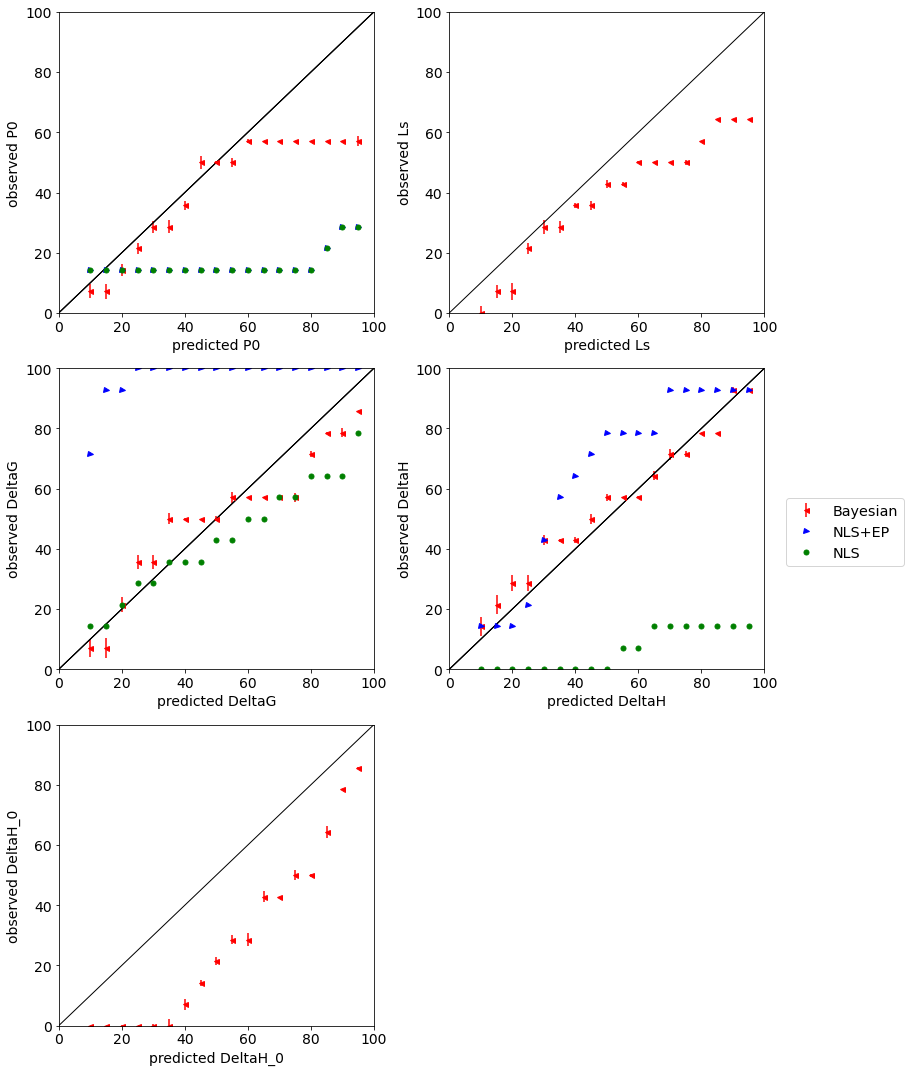

In [18]:
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(3, 2, figsize=(11, 5*3), sharex=False, sharey=False)
axes = axes.flatten()
for i in range(len(params_name)): 
    plot_containing_rates([LEVELS_PERCENT], [b_rates_list[params_name[i]]],
                          observed_rate_errors=[b_rate_errors_list[params_name[i]]],
                          xlabel=XLABEL+' '+params_name[i], ylabel=YLABEL+' '+params_name[i], 
                          xlimits=[0, 100], ylimits=[0, 100], markers=MARKERS[0], 
                          ax=axes[i], colors=COLORS[0], label='Bayesian', fontsize=14)
    try: 
        if os.path.exists(dir+out_dir_7+'/'+args.propagation_error_result_file):
            plot_containing_rates([LEVELS_PERCENT], [p_rate_list[params_name[i]]],
                                  observed_rate_errors=None,
                                  xlabel=XLABEL+' '+params_name[i], ylabel=YLABEL+' '+params_name[i], 
                                  xlimits=[0, 100], ylimits=[0, 100], markers=MARKERS[1], 
                                  ax=axes[i], colors=COLORS[1], label='NLS+EP', fontsize=14)
        plot_containing_rates([LEVELS_PERCENT], [g_rate_list[params_name[i]]],
                              observed_rate_errors=None,
                              xlabel=XLABEL+' '+params_name[i], ylabel=YLABEL+' '+params_name[i], 
                              xlimits=[0, 100], ylimits=[0, 100], markers=MARKERS[2], 
                              ax=axes[i], colors=COLORS[2], label='NLS', fontsize=14)
    except: 
        continue
    handles, labels = axes[i].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[5].set_visible(False)
legend = fig.legend(by_label.values(), by_label.keys(), loc='center right', 
                    bbox_to_anchor=(1.15, 0.5), fontsize = 'x-large');
plt.savefig(os.path.join(dir+out_dir_6, 'Containing_Plot_Origin'), 
            bbox_extra_artists=[legend], bbox_inches='tight')

# Save HTML

In [ ]:
!jupyter nbconvert "/content/drive/MyDrive/ITC/bitc_pymc3-master/bitc_Mg/20220501_MLE_ErrorPropagation.ipynb"